# 캐글 입문하기

- [housing data를 이용해서 집값 예측하기](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr) baseline 커널을 응용했다.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data' #cloud 환경으로 경로 변경

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(df_train.shape))
print('test data dim : {}'.format(df_test.shape)) #price column x

train data dim : (15035, 21)
test data dim : (6468, 20)


In [4]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
df_test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

##### 결측치는 흰색. 모두 검은색으로 표시돼 결측치가 없음을 알 수 있다.

<AxesSubplot:>

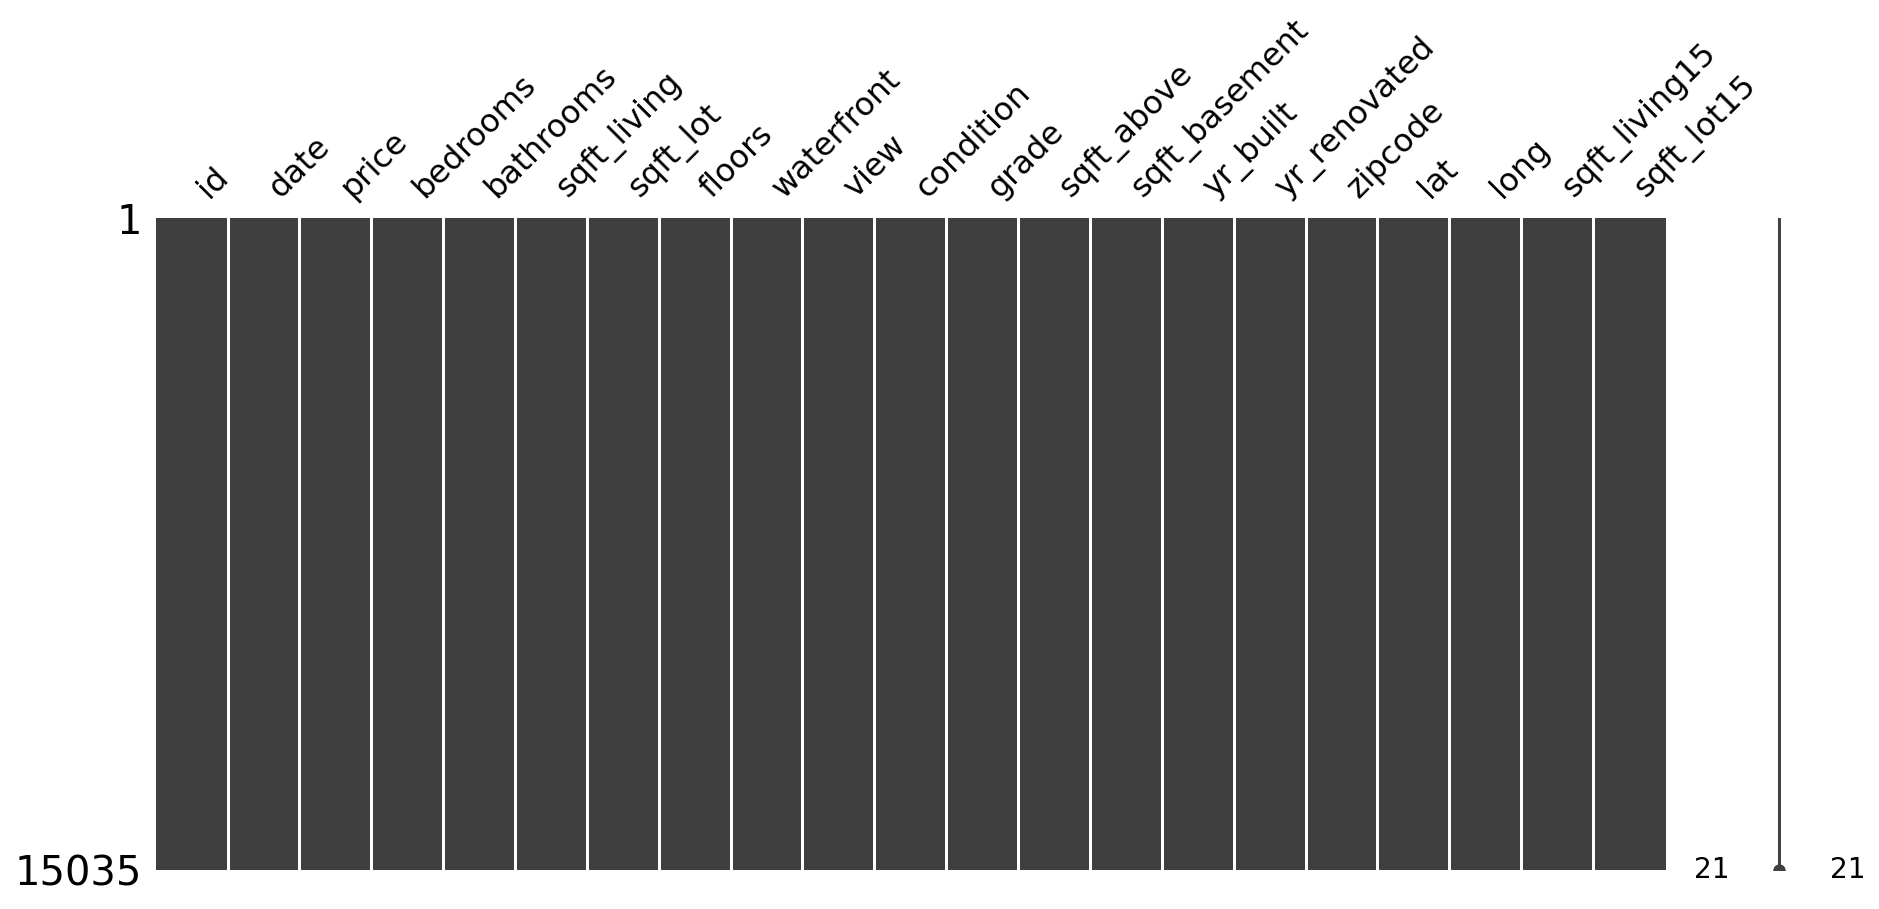

In [7]:
msno.matrix(df_train, figsize = (15,6))

<AxesSubplot:>

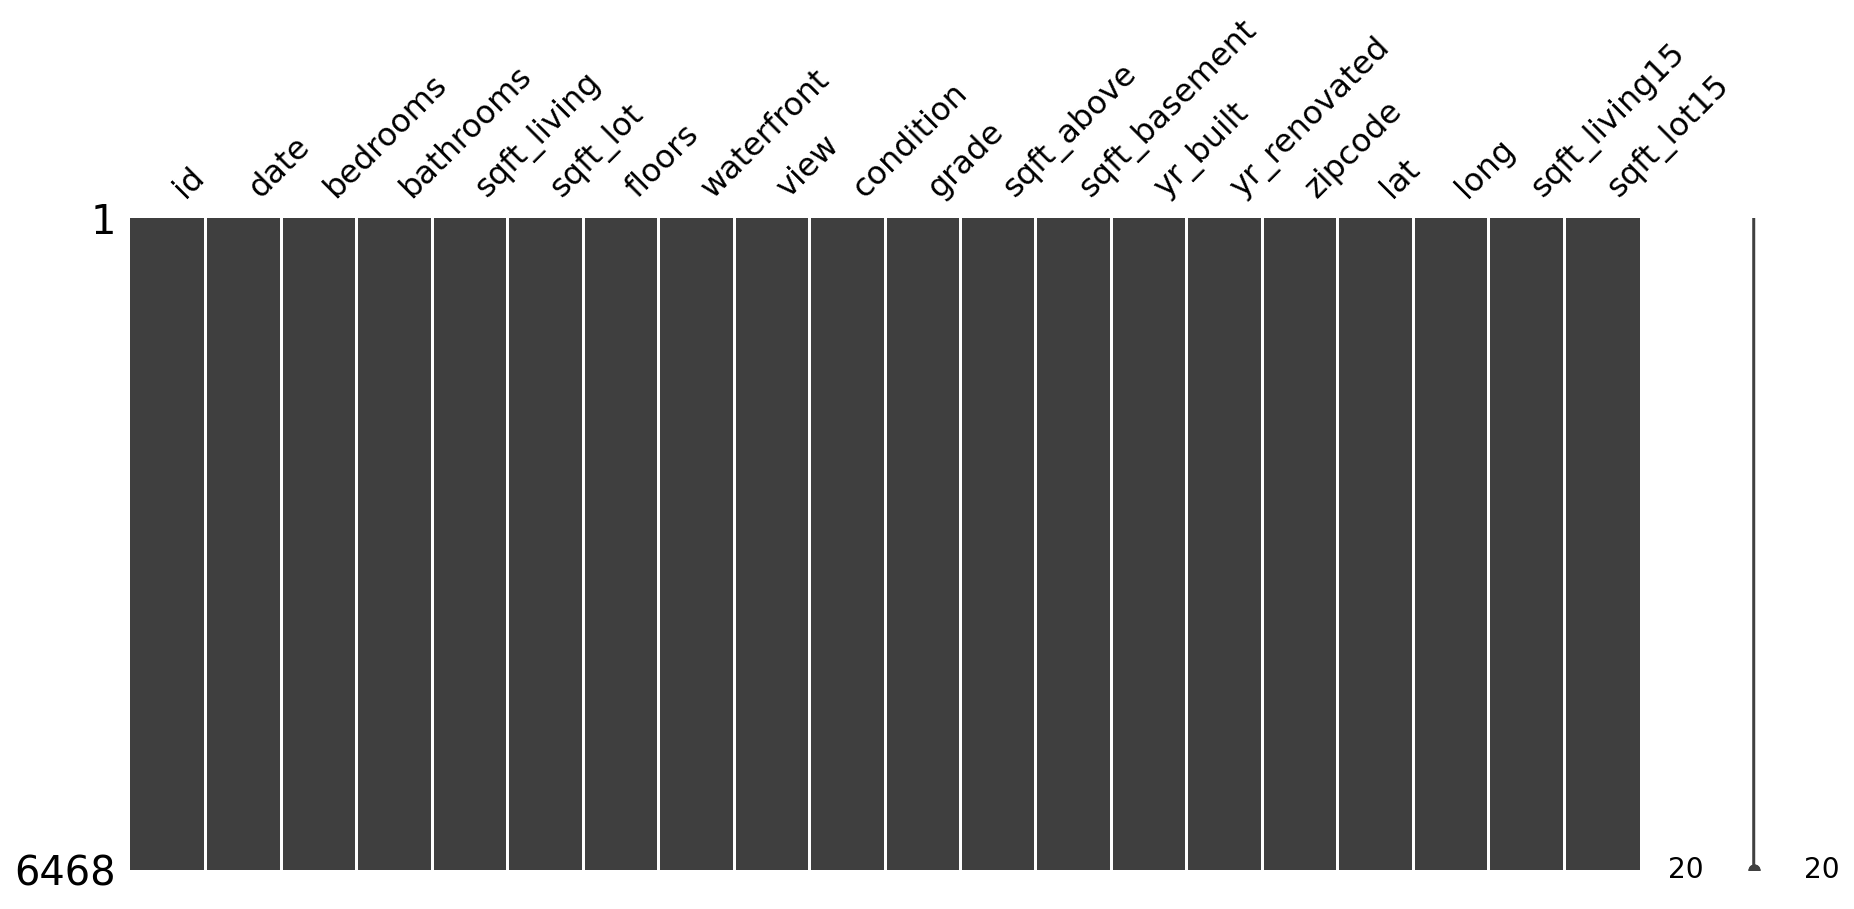

In [8]:
msno.matrix(df_test,figsize = (15,6))

### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다. 또한 data 변수는 범주형에서 숫자형으로 바꿔줍니다. 

In [9]:
test_id = df_test['id'] #id 저장.
del df_test['id']

del df_train["id"]

df_train['date'] = df_train['date'].apply(lambda x : str(x[:6])).astype(int)
df_test['date'] = df_test['date'].apply(lambda x : str(x[:6])).astype(int)

### 변수 간의 상관 관계 확인

![image](https://t1.daumcdn.net/cfile/tistory/99C148495C6AA1AA16)

범주형 변수가 섞여 있으므로 spearman 상관 계수 활용!

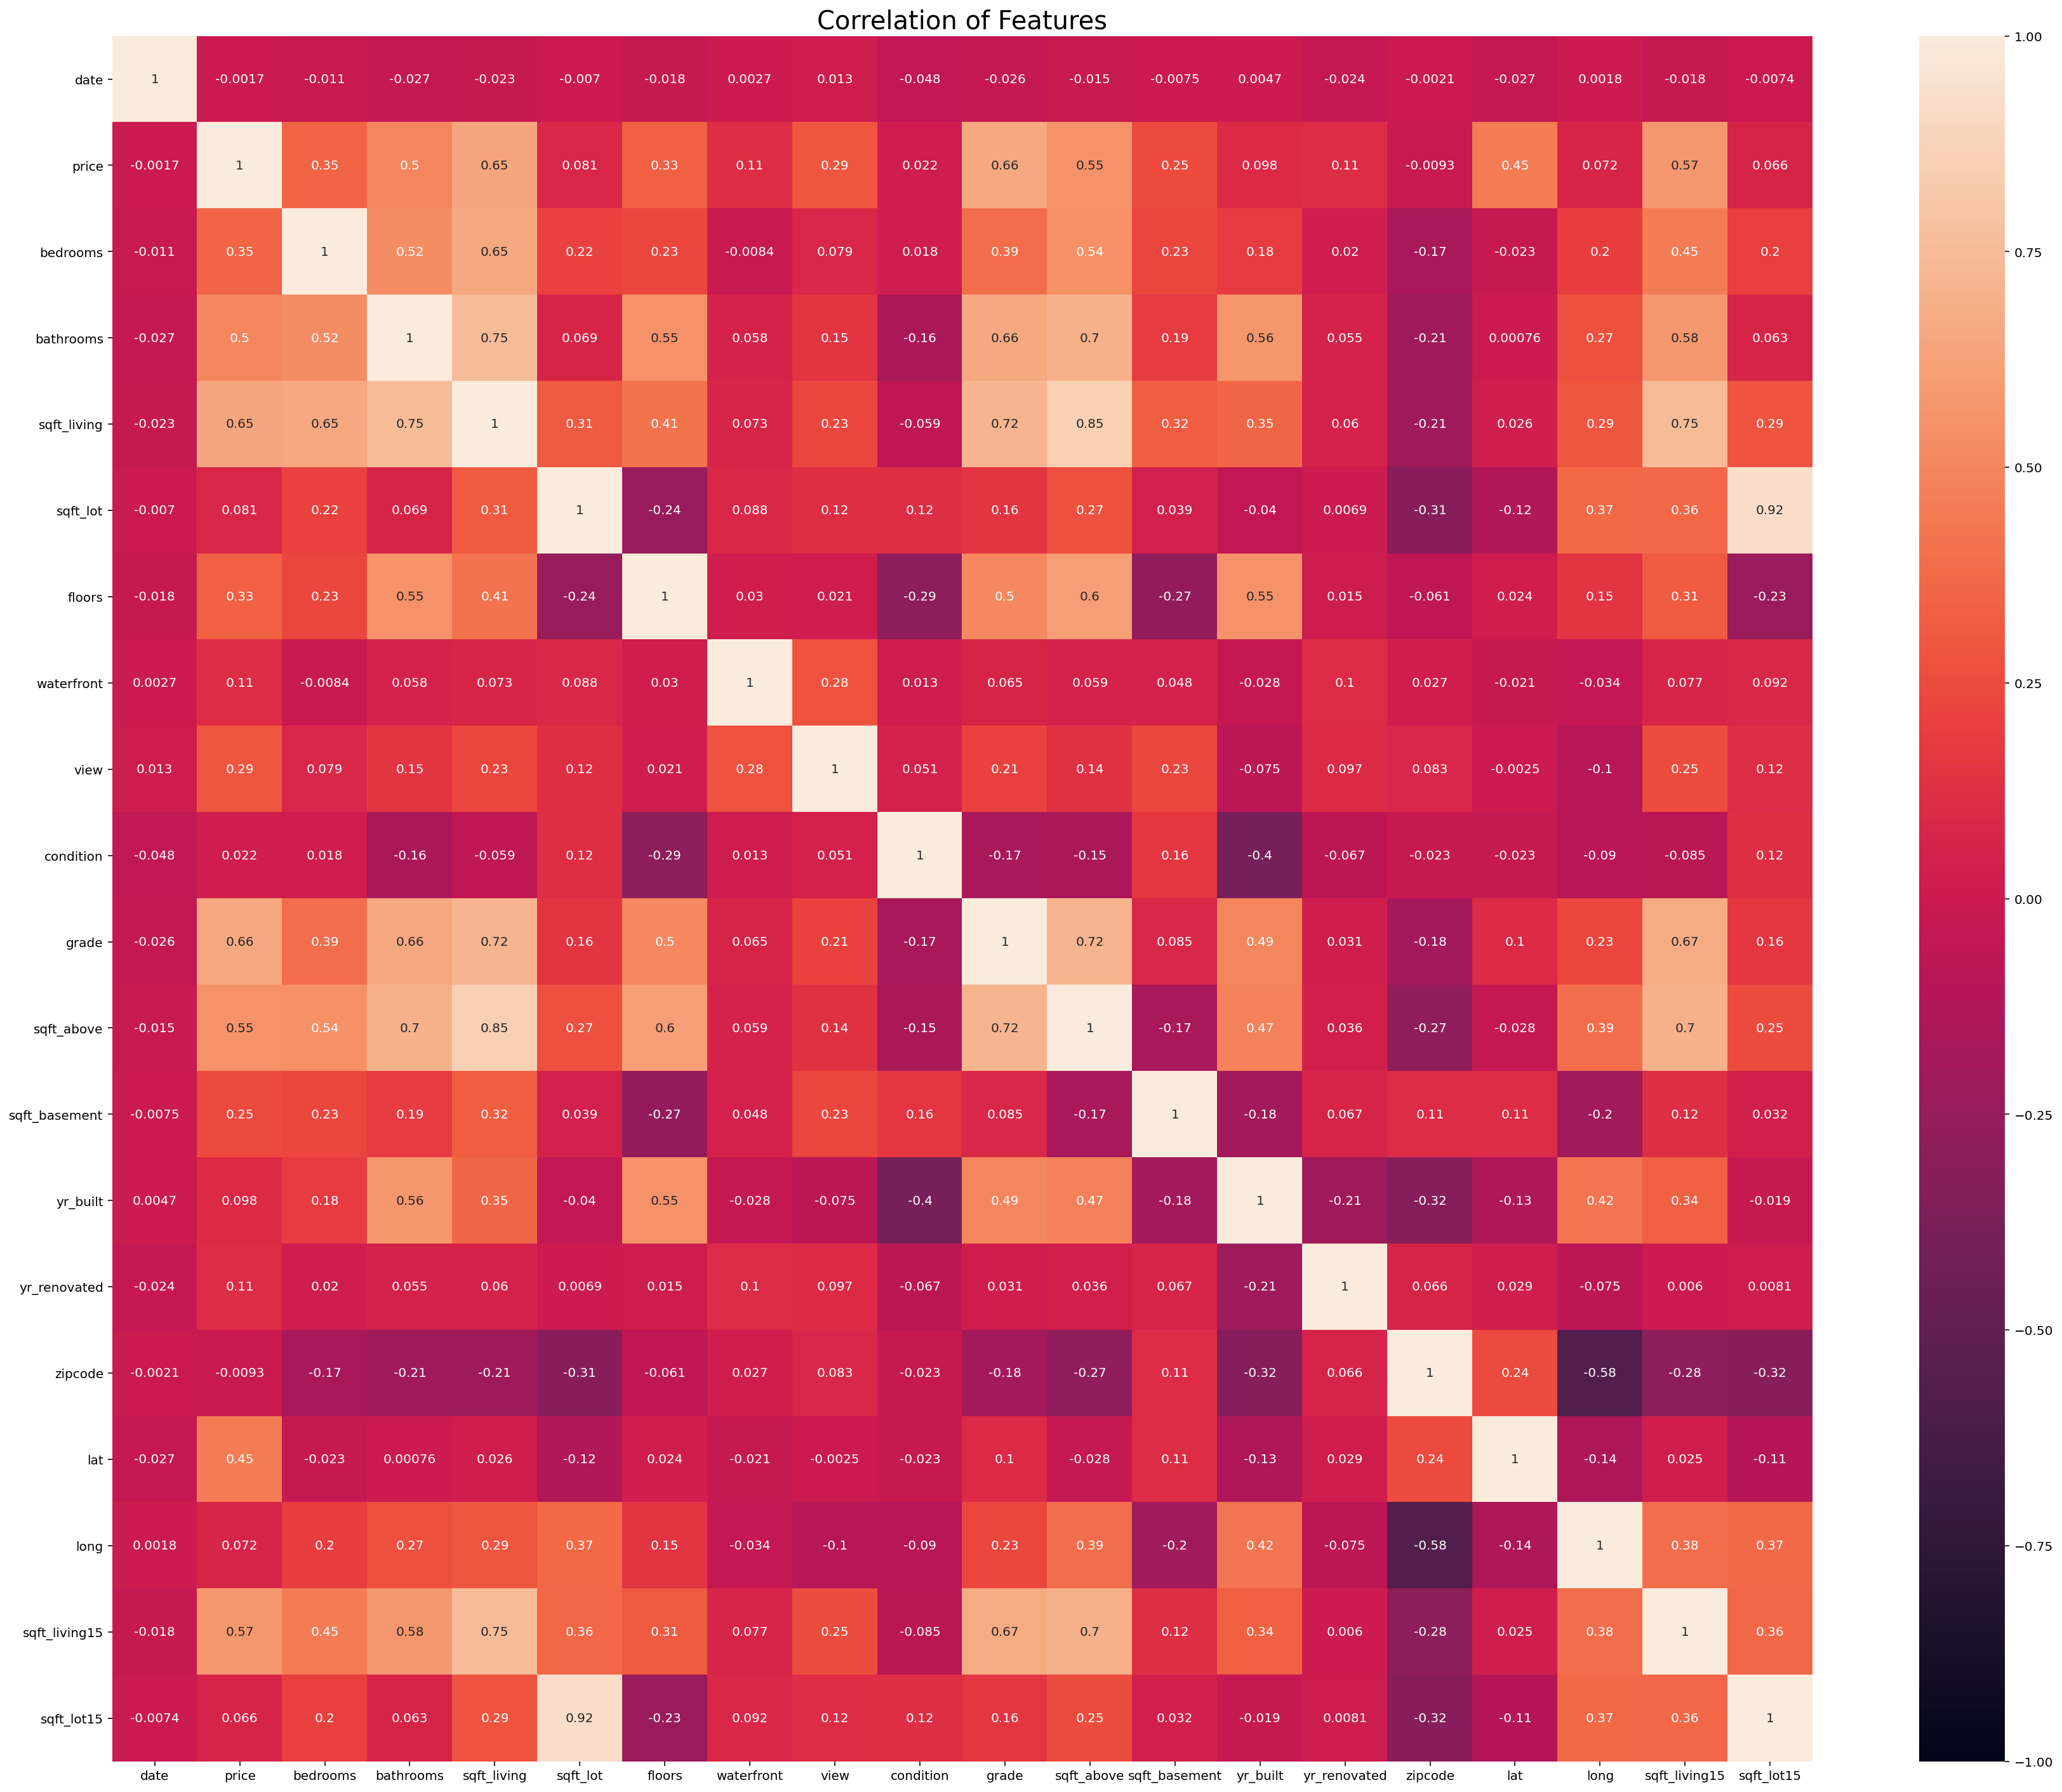

In [10]:
plt.figure(figsize=(30,25))

plt.title("Correlation of Features",size = 20)
sns.heatmap(df_train.corr(method='spearman'),vmin=-1,vmax=+1,annot=True)  #default가 pearson
plt.show()

#### 상관 관계가 큰 13개만 뽑는다.

- sqft_living ~ view 특성 : 0.4 이상. price와의 상관 관계가 있다!

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated']


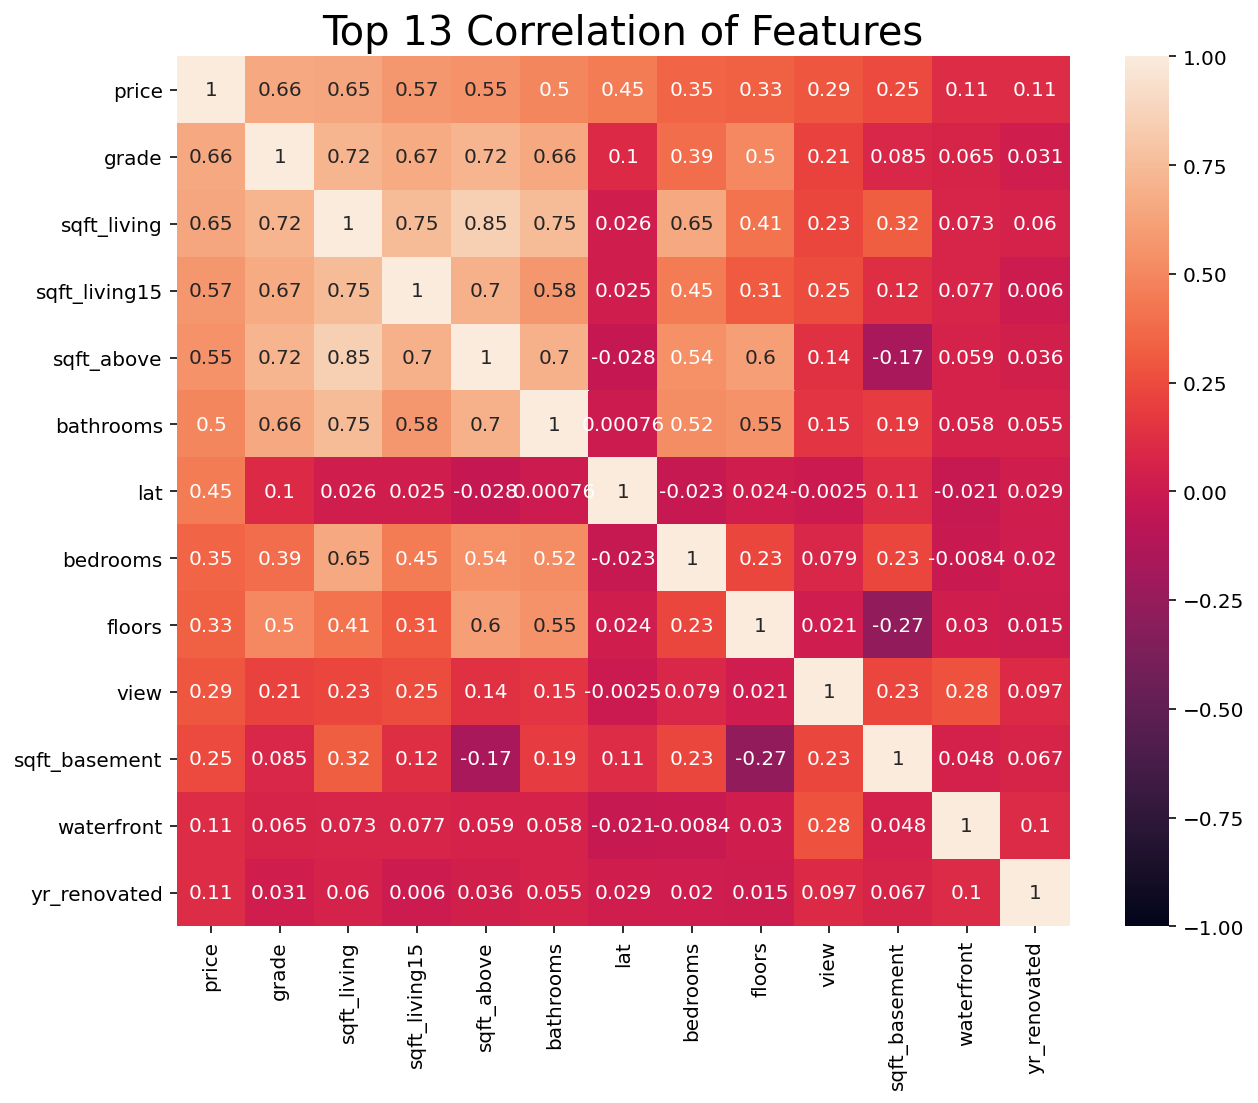

In [11]:
import scipy as sp

plt.figure(figsize=(10,8))

cor_abs = abs(df_train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=13, columns='price').index
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10

print(cor_cols.values)

plt.title("Top 13 Correlation of Features",size = 20)
sns.heatmap(cor,vmin=-1,vmax=+1,annot=True, xticklabels=cor_cols.values, yticklabels=cor_cols.values)  #default가 pearson
plt.show()

### 각 변수간의 상관 계수가 큰 것으로 보아 다중 공선성 존재?

- VIF값이 10보다 크다면 다중 공선성 존재

#### 대부분 다중 공선성 존재 -> Tree 기반 모델 사용!!

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

vif["Features"] = df_train.columns
vif["VIF values"] = [variance_inflation_factor(df_train.values,i) for i in range(df_train.shape[1])]

vif.sort_values(by='VIF values', ascending=False)

,Features,VIF values
11,sqft_above,inf
4,sqft_living,inf
12,sqft_basement,inf
15,zipcode,5.013305e+06
0,date,3.783820e+06
17,long,1.380403e+06
16,lat,1.590305e+05
13,yr_built,1.140849e+04
10,grade,1.602600e+02
9,condition,3.597290e+01


## 3. Feature Enginerring

### 수치형 변수 확인

#### 이상치가 많아보여 확인 후 처리.

<AxesSubplot:xlabel='sqft_lot15', ylabel='price'>

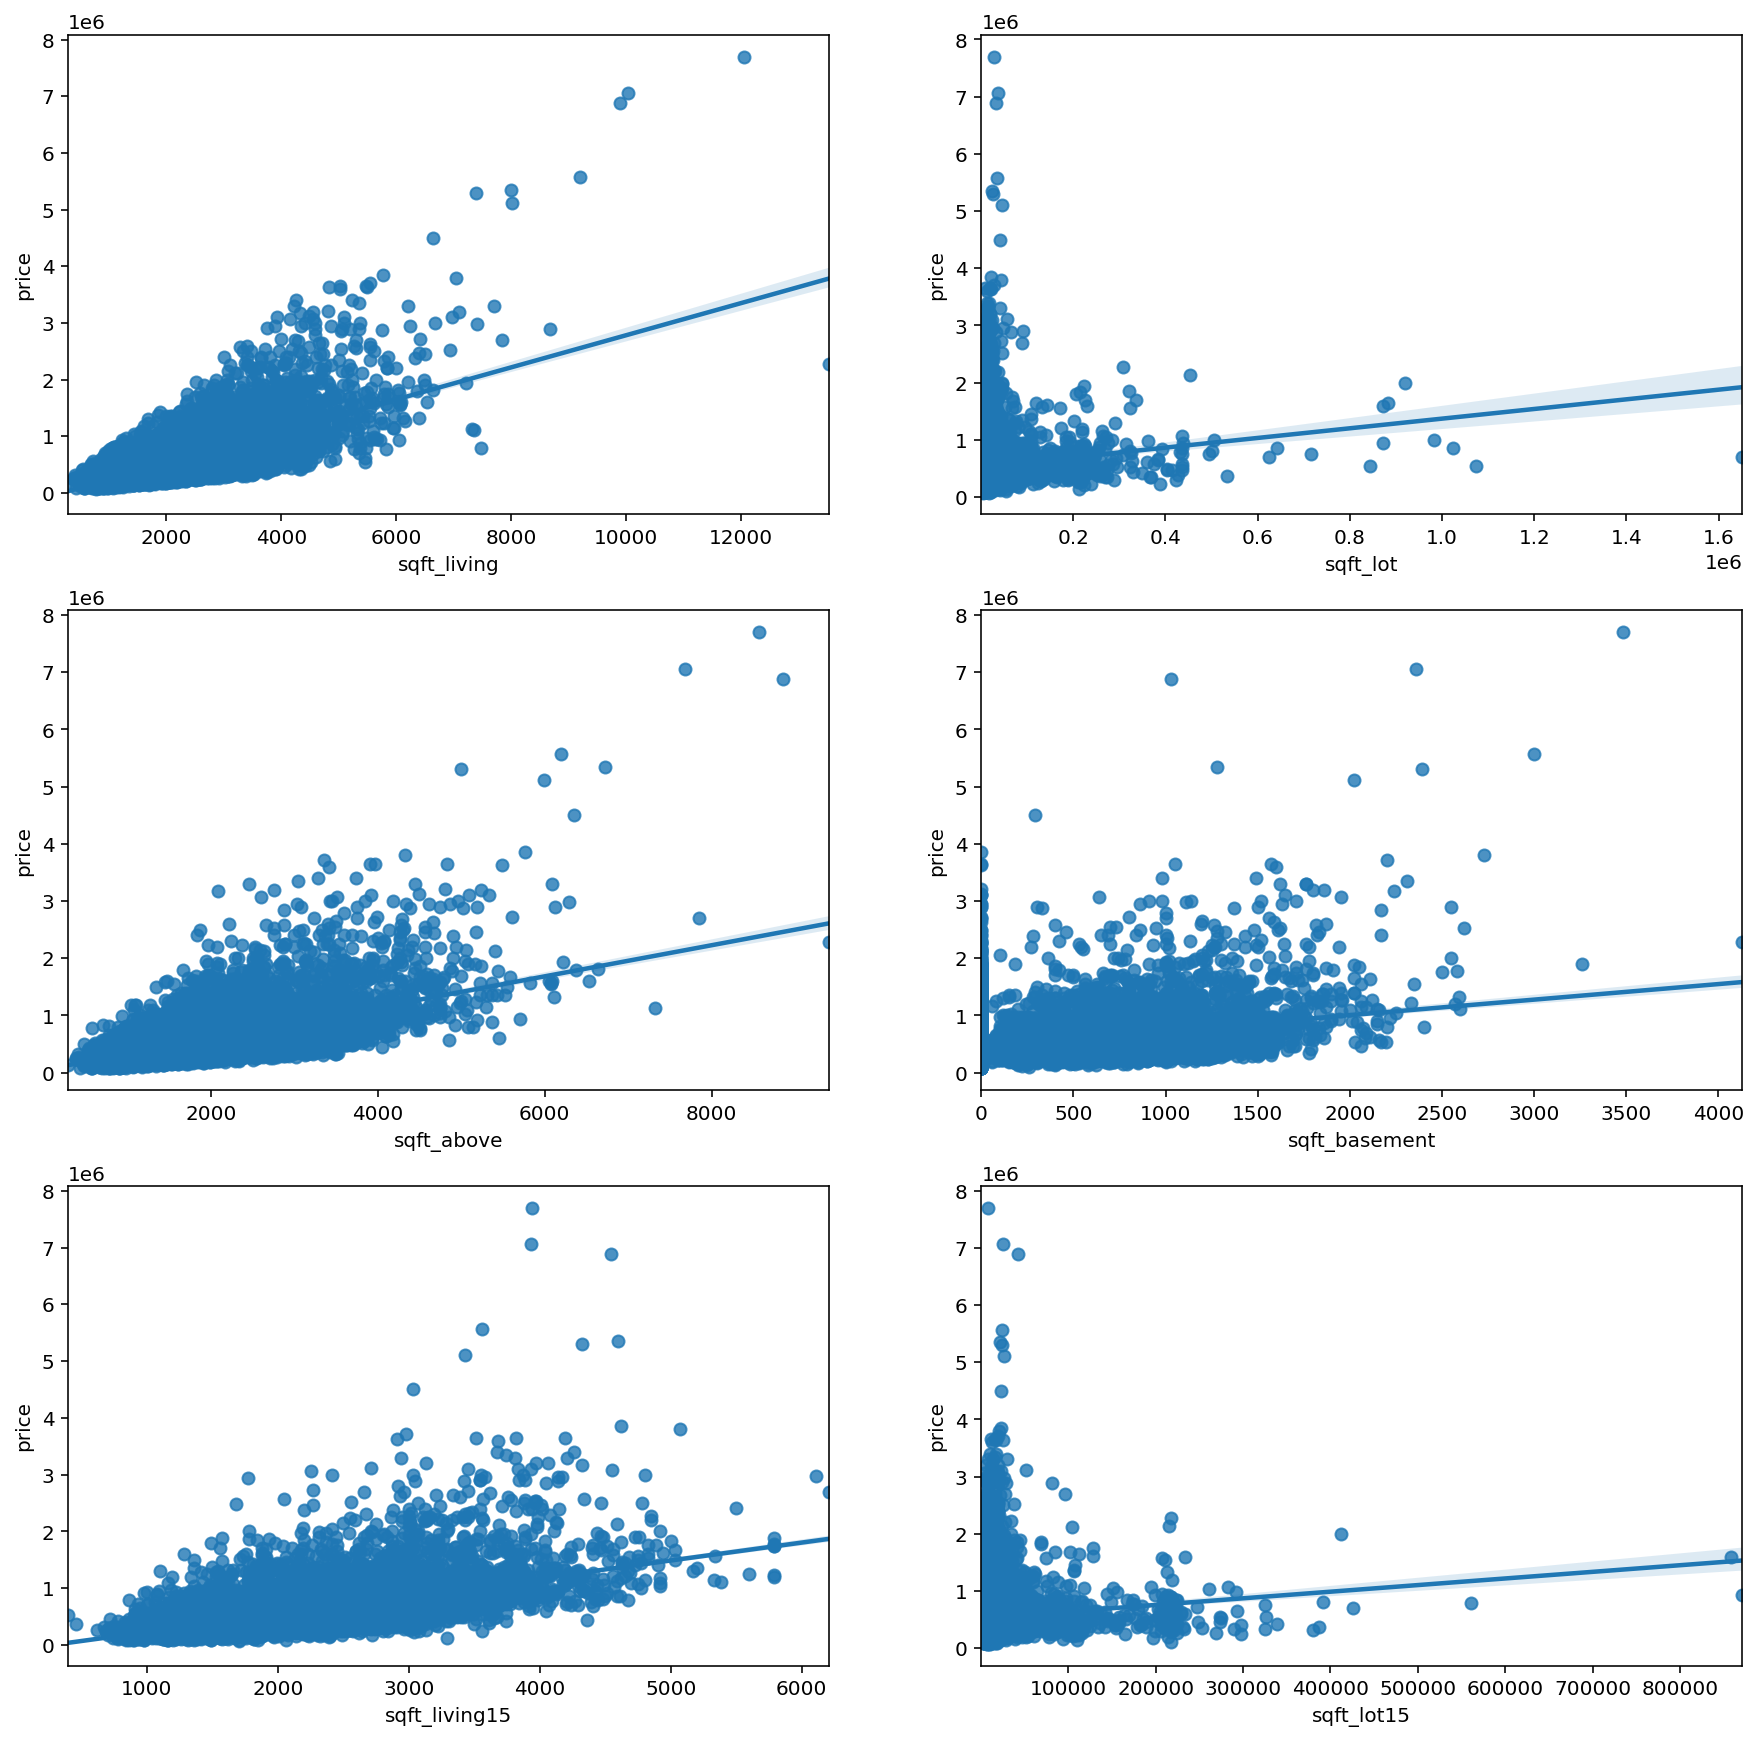

In [13]:
# 수치형 변수 시각화
fix , ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(15,15))

sqft_living_price = pd.concat([df_train['price'],df_train['sqft_living']], axis = 1)
sns.regplot(x = 'sqft_living',y = 'price', data = sqft_living_price, ax = ax1) #ax = ax[0]하면 접근 안됨.

sqft_lot_price = pd.concat([df_train['price'],df_train['sqft_lot']], axis = 1)
sns.regplot(x = 'sqft_lot',y = 'price', data = sqft_lot_price, ax = ax2) #ax = ax[0]하면 접근 안됨.

sqft_above_price = pd.concat([df_train['price'],df_train['sqft_above']], axis = 1)
sns.regplot(x = 'sqft_above',y = 'price', data = sqft_above_price, ax = ax3) #ax = ax[0]하면 접근 안됨.

sqft_basement_price = pd.concat([df_train['price'],df_train['sqft_basement']], axis = 1)
sns.regplot(x = 'sqft_basement',y = 'price', data = sqft_basement_price, ax = ax4) #ax = ax[0]하면 접근 안됨.

sqft_living15_price = pd.concat([df_train['price'],df_train['sqft_living15']], axis = 1)
sns.regplot(x = 'sqft_living15',y = 'price', data = sqft_living15_price, ax = ax5) #ax = ax[0]하면 접근 안됨.

sqft_lot15_price = pd.concat([df_train['price'],df_train['sqft_lot15']], axis = 1)
sns.regplot(x = 'sqft_lot15',y = 'price', data = sqft_lot15_price, ax = ax6) #ax = ax[0]하면 접근 안됨.

In [14]:
df_train.loc[df_train.sqft_living > 13000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,201405,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [15]:
df_train.loc[df_train.sqft_lot > 1.6*10**6]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1231,201503,700000.0,4,1.0,1300,1651359,1.0,0,3,4,6,1300,0,1920,0,98022,47.2313,-122.023,2560,425581


8912 data의 경우 조건들이 좋음에도 지나치게 낮은 가격. 이상치로 생각.

In [16]:
df_train.loc[df_train.sqft_above > 7500]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,201406,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
5108,201410,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,201409,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
8912,201405,2280000.0,7,8.00,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800
13809,201501,2700000.0,4,4.00,7850,89651,2.0,0,0,3,12,7850,0,2006,0,98027,47.5406,-121.982,6210,95832


In [17]:
df_train.drop([8912], axis=0, inplace=True)

In [18]:
df_train.loc[(df_train.sqft_basement > 0) & (df_train.price > 4*10**6)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
842,201410,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
947,201504,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1045,201504,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
1882,201408,4500000.0,5,5.50,6640,40014,2.0,1,4,3,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408
2775,201406,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
3134,201408,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
5108,201410,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,201409,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


In [19]:
df_train.loc[(df_train.sqft_living15 > 0) & (df_train.price > 4*10**6)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
842,201410,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
947,201504,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1045,201504,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
1882,201408,4500000.0,5,5.50,6640,40014,2.0,1,4,3,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408
2775,201406,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
3134,201408,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
5108,201410,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,201409,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


In [20]:
df_train.loc[(df_train.sqft_lot15 > 0) & (df_train.price > 4*10**6)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
842,201410,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
947,201504,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1045,201504,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
1882,201408,4500000.0,5,5.50,6640,40014,2.0,1,4,3,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408
2775,201406,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
3134,201408,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
5108,201410,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,201409,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


In [21]:
df_train.loc[df_train.sqft_lot15 > 800000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6779,201501,937500.0,4,4.0,5545,871200,2.0,0,0,3,11,3605,1940,2003,0,98014,47.676,-121.882,3420,871200
14225,201504,1600000.0,4,5.5,6530,871200,2.0,0,2,3,11,6530,0,2008,0,98014,47.664,-121.878,1280,858132


### lat , long 데이터는?

지도에 표시한 결과 집들이 특정 지역에 모여 있음을 알 수 있었고 부동산 특성상 위치 정보가 중요하다고 판단해 별다른 처리 없이 그대로 두기로 했다.

In [105]:
import folium

#지도의 중심을 지정하기 위해 위도와 경도의 평균 구하기

ex = pd.concat([df_train['lat'],df_train['long']],axis = 1)

lat = ex['lat'].mean()
long = ex['long'].mean()

#지도 띄우기
m = folium.Map([lat,long],zoom_start=9)

for i in ex.index:
    sub_lat =  ex.loc[i,'lat']
    sub_long = ex.loc[i,'long']
    
    # 지도에 데이터 찍어서 보여주기
    folium.Circle([sub_lat,sub_long], tooltip = (sub_lat, sub_long), color = 'red', radius=50).add_to(m)
m

![image](https://user-images.githubusercontent.com/86637320/128886507-ea80d604-acf3-4ffe-ac76-58dded14e40b.png)

### 범주형 변수 확인

#### date- price

<AxesSubplot:xlabel='date', ylabel='price'>

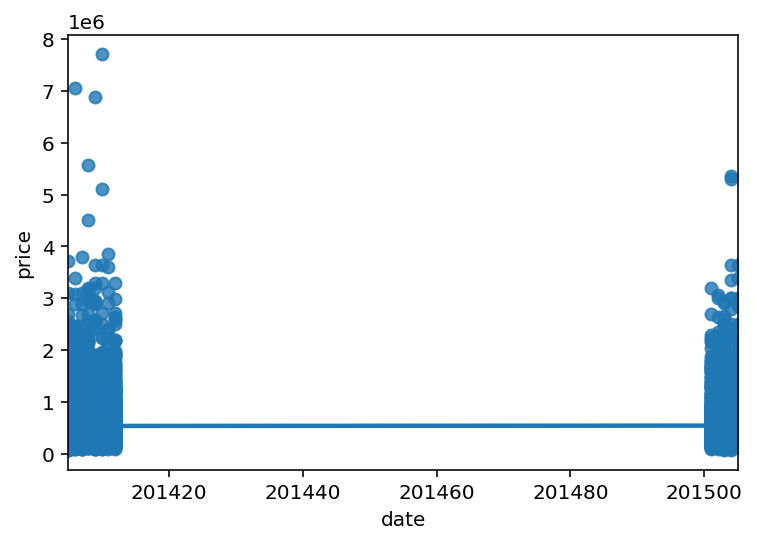

In [22]:
fig, ax =plt.subplots()

date_price = pd.concat([df_train['price'],df_train['date']],axis = 1)
sns.regplot(x = 'date',y = 'price', data = date_price)

date의 연, 월을 분리

#### 겹치는 월 데이터가 부족해 정확한 판단을 할 순 없지만 date를 넣는 것 보다는 month와 year를 넣는 것이 나을 것이다.

#### 계약 시기로 이상치 여부를 확인할 필요는 없다고 생각해 이상치는 그대로 둔다.

<AxesSubplot:xlabel='month', ylabel='price'>

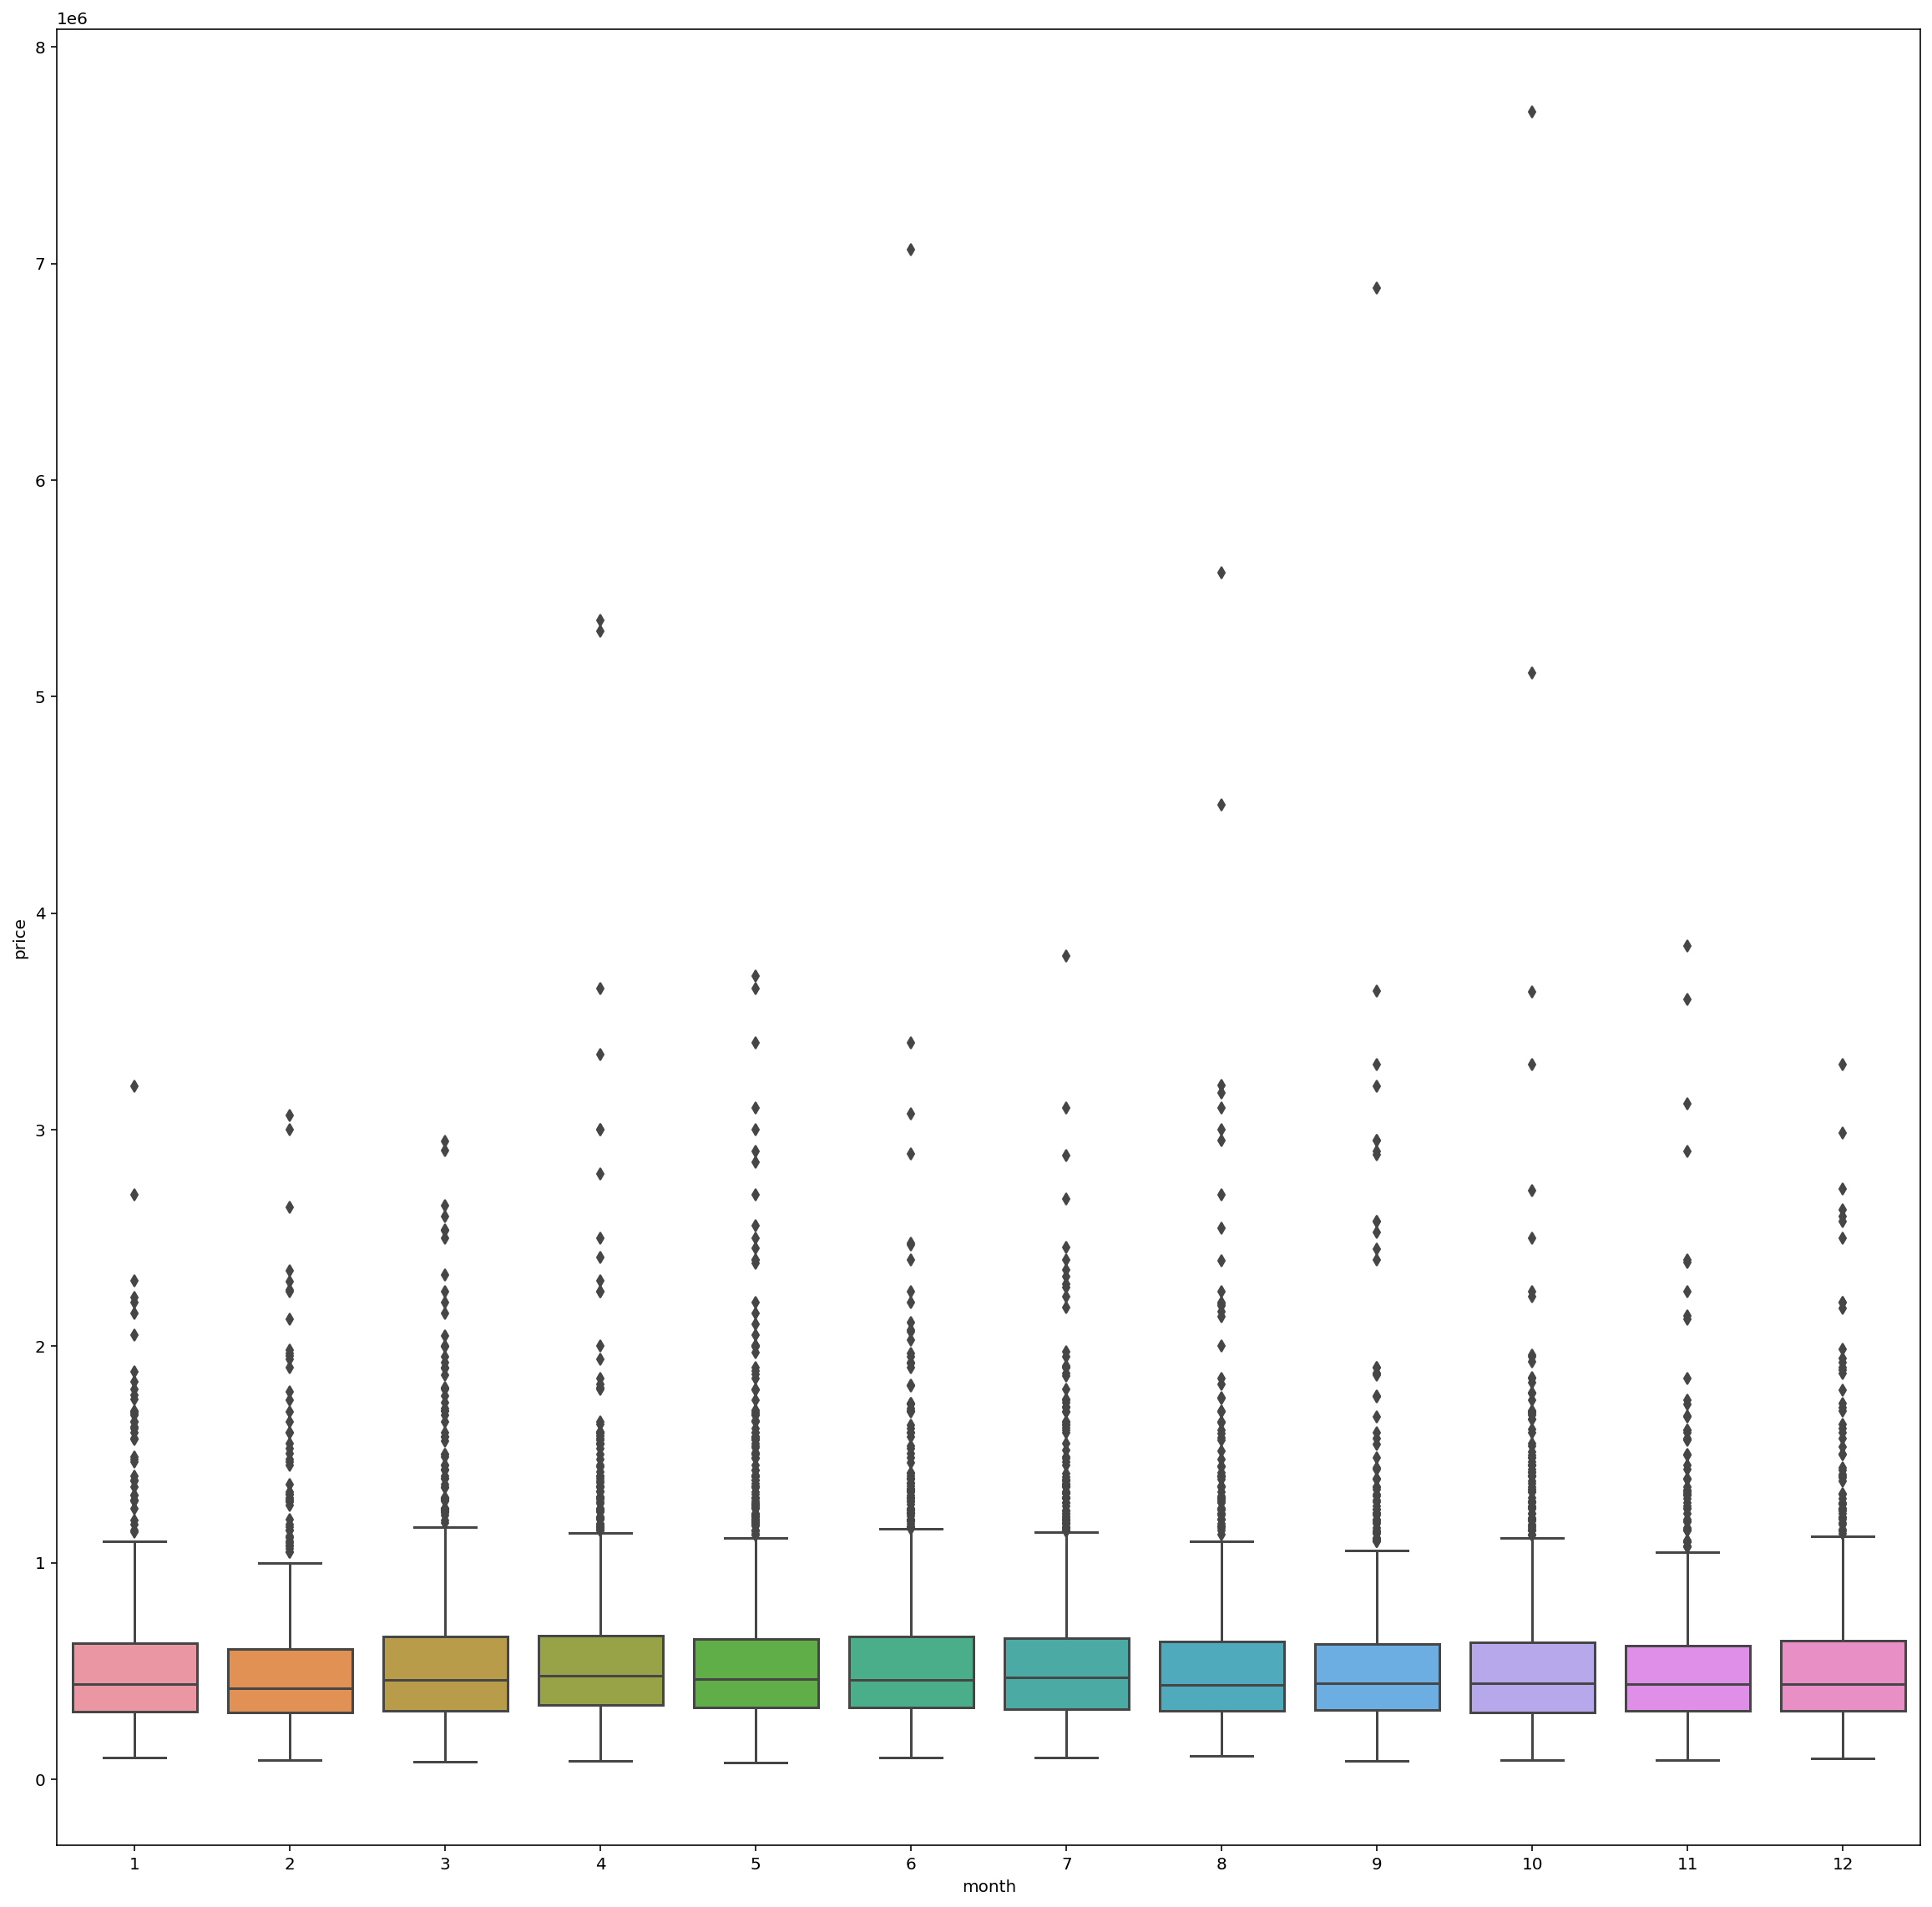

In [23]:
df_train["month"] = df_train['date'].apply(lambda x : x%100)
df_train["year"] = df_train['date'].apply(lambda x : x%10000//100)
df_test["month"] = df_test['date'].apply(lambda x : x%100)
df_test["year"] = df_test['date'].apply(lambda x : x%10000//100)

plt.figure(figsize=(20,20))
sns.boxplot(x='month',y = 'price',data = df_train)

<AxesSubplot:xlabel='month', ylabel='price'>

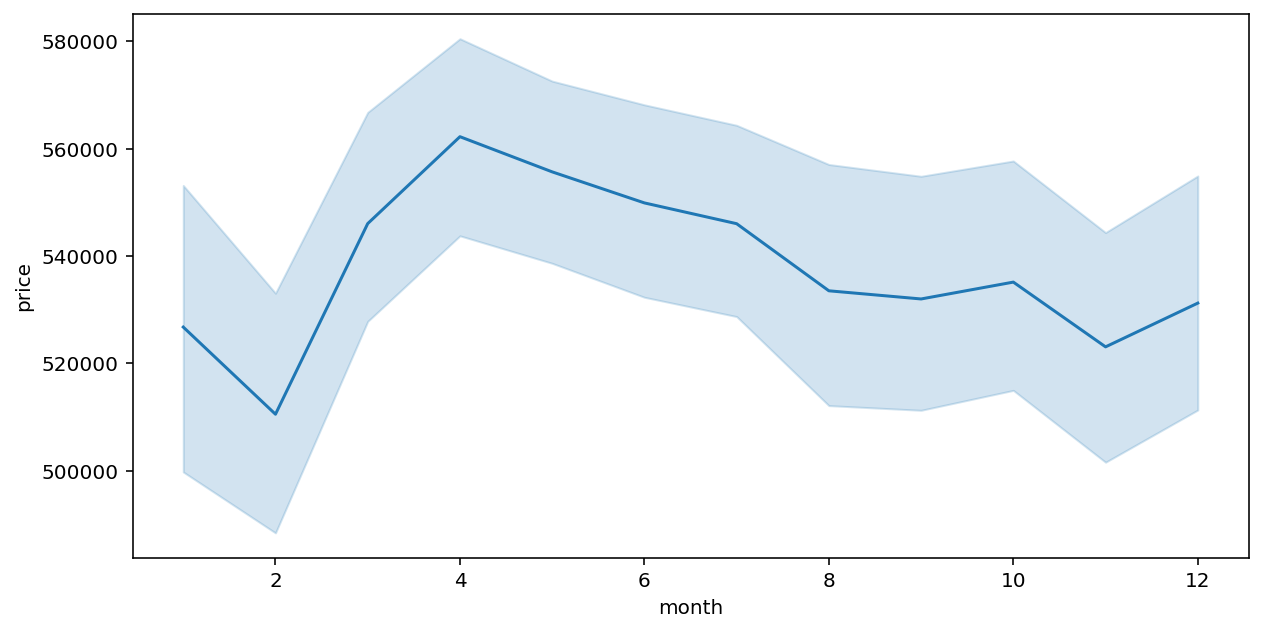

In [24]:
plt.figure(figsize=(10,5))
sns.lineplot(x=df_train['month'], y=df_train['price'])

#### grade - price

grade 3, 11에서 이상치 발생

In [25]:
df_train[["grade", "price"]].groupby(["grade"], as_index = True).describe()

price                                                               \
        count          mean           std        min        25%        50%   
grade                                                                        
1         1.0  1.420000e+05           NaN   142000.0   142000.0   142000.0   
3         2.0  2.710000e+05  1.272792e+04   262000.0   266500.0   271000.0   
4        23.0  2.097413e+05  9.610089e+04    80000.0   145000.0   200000.0   
5       174.0  2.510696e+05  1.248287e+05    78000.0   172375.0   227475.0   
6      1406.0  3.001554e+05  1.210734e+05    84000.0   215000.0   274600.0   
7      6228.0  4.015281e+05  1.538019e+05    90000.0   285000.0   375000.0   
8      4207.0  5.423156e+05  2.146832e+05   140000.0   390000.0   512500.0   
9      1855.0  7.734781e+05  3.158378e+05   230000.0   570500.0   725000.0   
10      781.0  1.062482e+06  4.710331e+05   316000.0   767450.0   908990.0   
11      288.0  1.522459e+06  7.345273e+05   550000.0  1036500.0  1288000.0   
12       60.0  2.219549e+06  1.045295e+06   835000.0  1543750.0  1810000.0   
13        9.0  4.132333e+06  2.085904e+06  1780000.0  2888000.0  3200000.0   

                             
             75%        max  
grade                        
1       142000.0   142000.0  
3       275500.0   280000.0  
4       256500.0   435000.0  
5       297500.0   795000.0  
6       365000.0  1052000.0  
7       485000.0  2050000.0  
8       640000.0  2700000.0  
9       878500.0  2546000.0  
10     1250000.0  3600000.0  
11     1798750.0  7062500.0  
12     2763875.0  5350000.0  
13     5570000.0  7700000.0

<AxesSubplot:xlabel='grade', ylabel='price'>

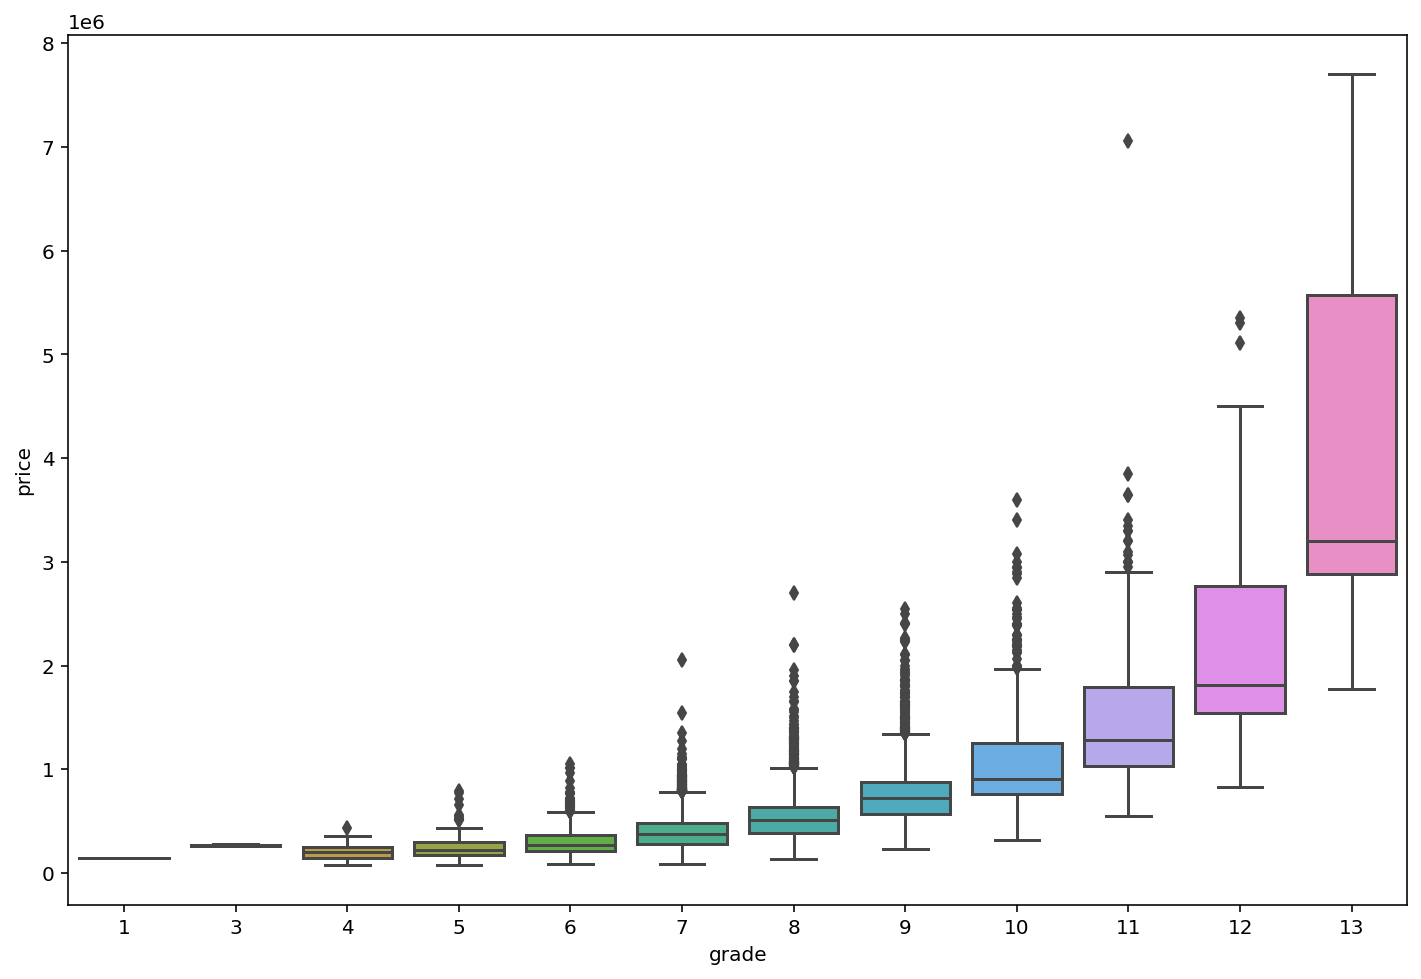

In [26]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.boxplot(x = df_train["grade"], y = df_train["price"], data = df_train, ax = ax)

grade = 3 일 때의 이상치 처리

In [27]:
df_train.loc[df_train.grade==3]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
2302,201502,262000.0,1,0.75,520,12981,1.0,0,0,5,...,0,1920,0,98022,47.2082,-121.995,1340,12233,2,15
4123,201411,280000.0,1,0.00,600,24501,1.0,0,0,2,...,0,1950,0,98045,47.5316,-121.749,990,22549,11,14


정말 이상치인지 price와 상관 관계가 높은 sqft_living을 통해 비교 + 다른 조건들도 별로라서 이상치로 판단.

In [28]:
print(df_train[df_train['grade']==3].sqft_living.mean())
print(df_train[df_train['grade']==4].sqft_living.mean())

560.0
689.7391304347826


In [29]:
df_train.drop([2302,4123], axis=0, inplace=True)

In [30]:
df_train.loc[(df_train.grade==11) & (df_train.price>6*10**6)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
2775,201406,7062500.0,5,4.5,10040,37325,2.0,1,2,3,...,2360,1940,2001,98004,47.65,-122.214,3930,25449,6,14


sqft_living 이 동일 grade 대비 월등하게 커 이상치 처리하지 않는다.

In [31]:
print(df_train[df_train['grade']==11].sqft_living.mean())
print(df_train[df_train['grade']==12].sqft_living.mean())

4391.135416666667
5264.883333333333


#### bedrooms - price

bedrooms가 증가함에 따라 선형적으로 증가. 이상치가 많아 다른 요소를 통해 제거한다.

In [32]:
df_train[["bedrooms", "price"]].groupby(["bedrooms"], as_index = True).describe()

price                                                             \
           count          mean            std       min       25%       50%   
bedrooms                                                                      
0            4.0  2.405000e+05   74505.033387  142000.0  211750.0  250000.0   
1          131.0  3.108890e+05  131250.046775   80000.0  228000.0  295000.0   
2         1931.0  3.992137e+05  194900.840176   78000.0  265000.0  370000.0   
3         6835.0  4.657418e+05  261322.681915   89000.0  298850.0  413450.0   
4         4797.0  6.340614e+05  382654.331315  100000.0  375000.0  549995.0   
5         1108.0  8.022583e+05  618801.129768  133000.0  439937.5  625000.0   
6          188.0  8.714031e+05  914632.397633  230000.0  433750.0  664500.0   
7           21.0  9.044218e+05  691051.689134  280000.0  539000.0  730000.0   
8           10.0  1.135300e+06  921998.318870  340000.0  601250.0  754000.0   
9            5.0  7.927998e+05  324267.322437  450000.0  599999.0  700000.0   
10           2.0  8.990000e+05  352139.177031  650000.0  774500.0  899000.0   

                                
                75%        max  
bedrooms                        
0          278750.0   320000.0  
1          385097.5   680000.0  
2          485000.0  1998000.0  
3          560000.0  3600000.0  
4          770000.0  3850000.0  
5          931300.0  7062500.0  
6          927500.0  7700000.0  
7          884900.0  2885000.0  
8         1462500.0  3300000.0  
9          934000.0  1280000.0  
10        1023500.0  1148000.0

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

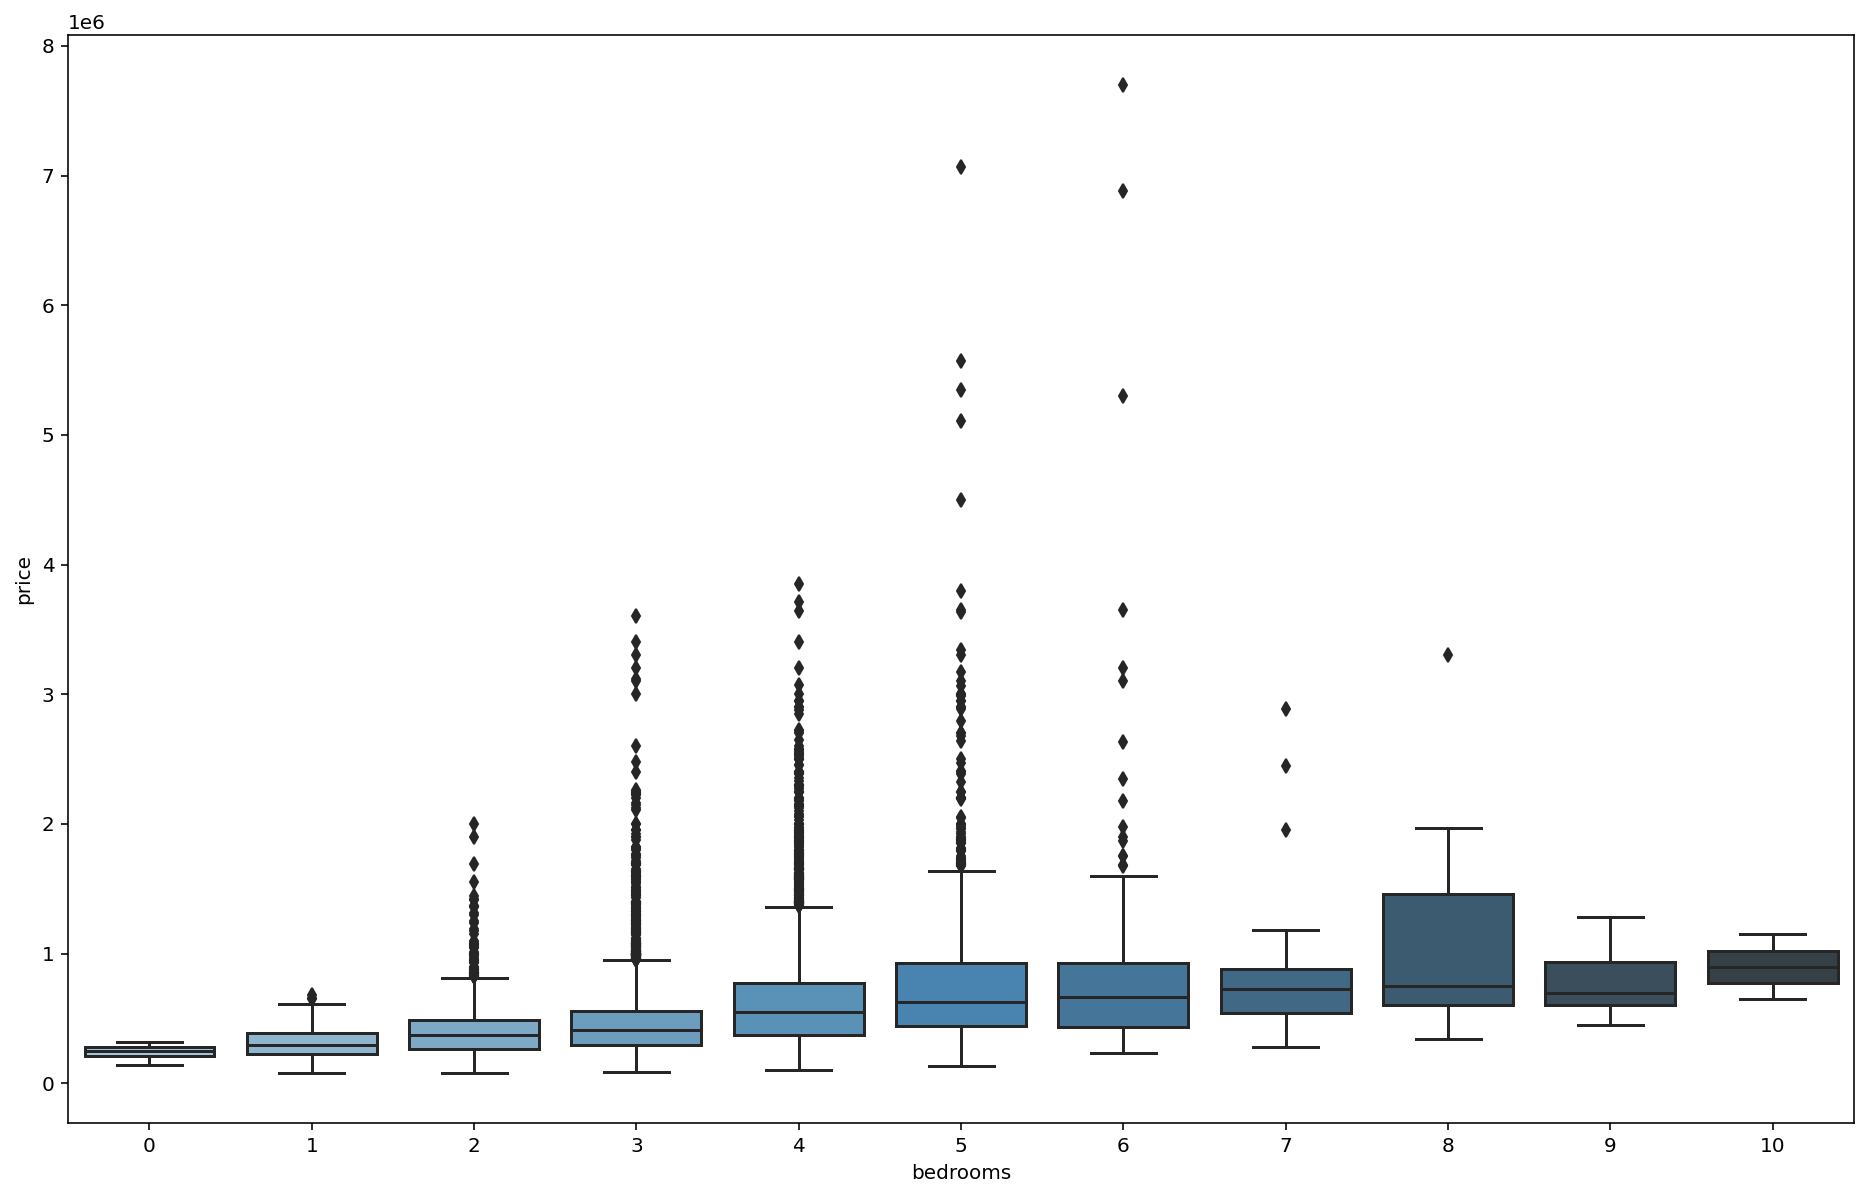

In [33]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.boxplot(x = df_train["bedrooms"], y = df_train["price"], data = df_train, ax = ax, palette = "Blues_d")

#### bathrooms - price

#### 선형적 관계. 4.5일 때 이상치 확인 필요!

In [34]:
df_train[["bathrooms", "price"]].groupby(["bathrooms"], as_index = True).describe()

price                                                    \
            count          mean           std        min        25%   
bathrooms                                                             
0.00          3.0  2.870000e+05  1.768304e+05   142000.0   188500.0   
0.50          3.0  2.123333e+05  8.994072e+04   109000.0   182000.0   
0.75         44.0  2.816761e+05  1.376289e+05    80000.0   187562.5   
1.00       2675.0  3.469929e+05  1.550331e+05    78000.0   230000.0   
1.25          5.0  6.082900e+05  4.511401e+05   275000.0   321950.0   
1.50       1009.0  4.052911e+05  1.848993e+05   107000.0   268000.0   
1.75       2112.0  4.516214e+05  1.954409e+05   137900.0   310000.0   
2.00       1357.0  4.628095e+05  2.075399e+05   133000.0   310000.0   
2.25       1433.0  5.309718e+05  2.758159e+05   160000.0   336750.0   
2.50       3748.0  5.558889e+05  2.691441e+05   153503.0   364997.0   
2.75        843.0  6.632313e+05  3.027376e+05   183750.0   449725.0   
3.00        493.0  7.151572e+05  4.336109e+05   154000.0   432500.0   
3.25        410.0  9.857819e+05  5.754154e+05   279900.0   599962.5   
3.50        510.0  9.180195e+05  4.782530e+05   216650.0   600000.0   
3.75        108.0  1.244784e+06  6.239338e+05   345100.0   806625.0   
4.00        100.0  1.247460e+06  7.051227e+05   265000.0   761250.0   
4.25         57.0  1.512515e+06  7.048725e+05   490000.0   955000.0   
4.50         64.0  1.329664e+06  9.683508e+05   290000.0   808000.0   
4.75         16.0  2.028452e+06  8.908661e+05   599000.0  1361250.0   
5.00         14.0  1.713750e+06  1.372669e+06   343000.0   687375.0   
5.25         11.0  1.898391e+06  1.336079e+06   300000.0  1211500.0   
5.50          7.0  2.640429e+06  1.238211e+06   925000.0  1875000.0   
5.75          3.0  2.683333e+06  2.596080e+06   540000.0  1240000.0   
6.00          2.0  4.467500e+06  1.177333e+06  3635000.0  4051250.0   
6.25          1.0  2.888000e+06           NaN  2888000.0  2888000.0   
6.75          1.0  8.000000e+05           NaN   800000.0   800000.0   
7.50          1.0  4.500000e+05           NaN   450000.0   450000.0   
7.75          1.0  6.885000e+06           NaN  6885000.0  6885000.0   
8.00          1.0  7.700000e+06           NaN  7700000.0  7700000.0   

                                             
                 50%         75%        max  
bathrooms                                    
0.00        235000.0   359500.00   484000.0  
0.50        255000.0   264000.00   273000.0  
0.75        250000.0   350500.00   785000.0  
1.00        320000.0   427350.00  1300000.0  
1.25        516500.0   540000.00  1388000.0  
1.50        369500.0   485000.00  1465000.0  
1.75        420000.0   550338.75  2100000.0  
2.00        430000.0   565000.00  2200000.0  
2.25        468000.0   625000.00  2400000.0  
2.50        500000.0   675000.00  2903000.0  
2.75        615000.0   798400.00  2180000.0  
3.00        610000.0   855000.00  3100000.0  
3.25        842000.0  1200000.00  3640900.0  
3.50        810000.0  1109365.00  3710000.0  
3.75       1137500.0  1528000.00  3650000.0  
4.00       1050000.0  1493750.00  3400000.0  
4.25       1400000.0  1900000.00  3850000.0  
4.50       1061500.0  1577222.50  7062500.0  
4.75       1947500.0  2647500.00  3650000.0  
5.00       1512500.0  1846250.00  5350000.0  
5.25       1415000.0  2354000.00  5110800.0  
5.50       2525000.0  3391500.00  4500000.0  
5.75       1940000.0  3755000.00  5570000.0  
6.00       4467500.0  4883750.00  5300000.0  
6.25       2888000.0  2888000.00  2888000.0  
6.75        800000.0   800000.00   800000.0  
7.50        450000.0   450000.00   450000.0  
7.75       6885000.0  6885000.00  6885000.0  
8.00       7700000.0  7700000.00  7700000.0

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

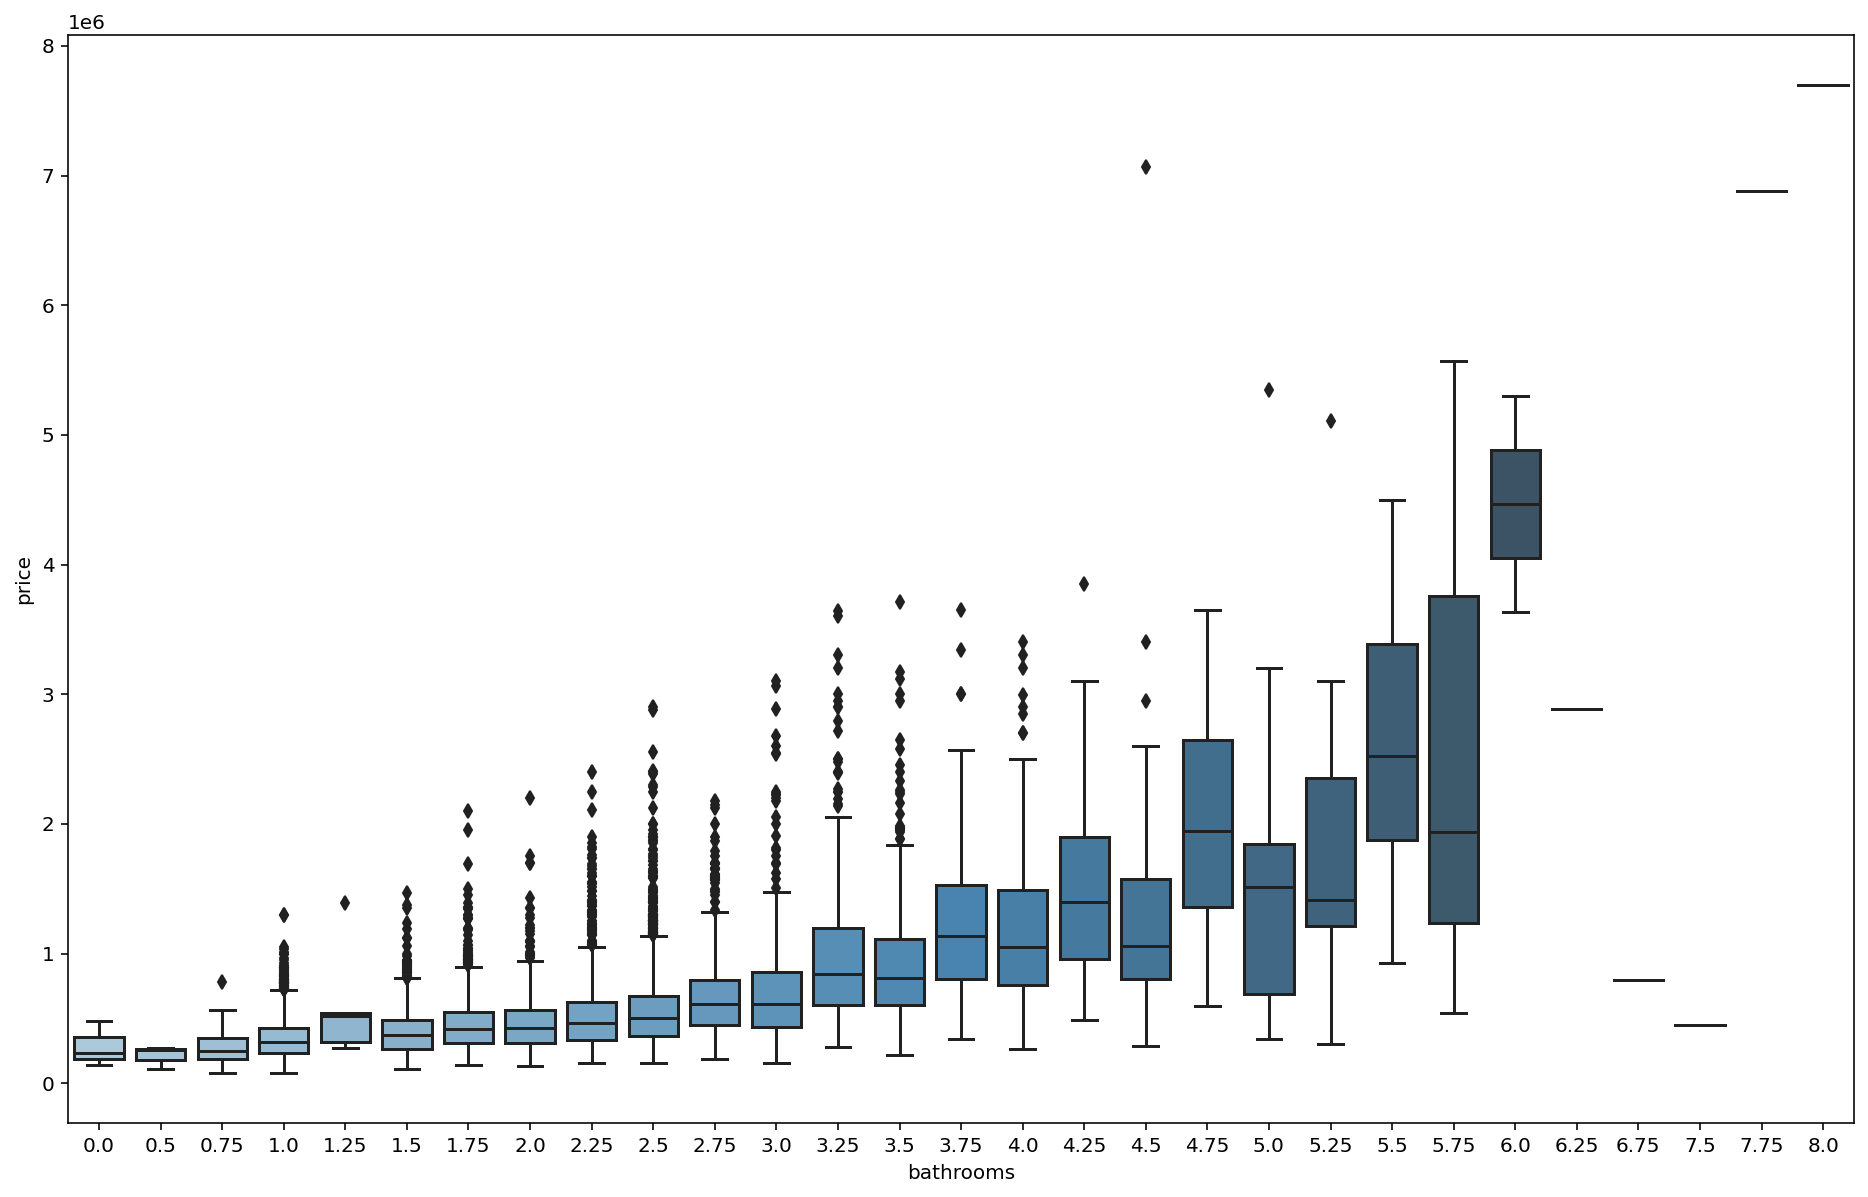

In [35]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.boxplot(x = df_train["bathrooms"], y = df_train["price"], data = df_train, ax = ax, palette = "Blues_d")

In [36]:
df_train.loc[(df_train.bathrooms==4.5) & (df_train.price > 6*10**6)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
2775,201406,7062500.0,5,4.5,10040,37325,2.0,1,2,3,...,2360,1940,2001,98004,47.65,-122.214,3930,25449,6,14


sqft_living의 크기가 bathrooms 등급에 비해서 매우 크기 때문에 이상치 X

In [37]:
print(df_train[df_train['bathrooms']==4.5].sqft_living.mean())
print(df_train[df_train['bathrooms']==4.75].sqft_living.mean())

4323.34375
5324.0625


#### floors - price

In [38]:
df_train[["floors", "price"]].groupby(["floors"], as_index = True).describe()

# 층수의 경우 1.5, 2.5, 3.5와 같이 소숫점을 가진다. 
# 미국에서 흔히 볼 수 있는 형태로 다락방을 끼고 있는 형태

price                                                            \
         count          mean           std       min       25%       50%   
floors                                                                     
1.0     7359.0  4.397287e+05  2.595194e+05   78000.0  275000.0  389000.0   
1.5     1330.0  5.577378e+05  3.116443e+05  123000.0  350000.0  525000.0   
2.0     5810.0  6.503442e+05  4.391244e+05   90000.0  379500.0  545900.0   
2.5      113.0  1.022214e+06  8.995638e+05  255000.0  542500.0  750000.0   
3.0      416.0  6.005717e+05  3.672744e+05  208400.0  384250.0  500000.0   
3.5        4.0  1.184750e+06  1.410645e+06  435000.0  468000.0  502000.0   

                              
              75%        max  
floors                        
1.0      525000.0  3800000.0  
1.5      690000.0  3650000.0  
2.0      775000.0  7062500.0  
2.5     1225000.0  7700000.0  
3.0      640000.0  3100000.0  
3.5     1218750.0  3300000.0

2.5일 때 이상치 확인

<AxesSubplot:xlabel='floors', ylabel='price'>

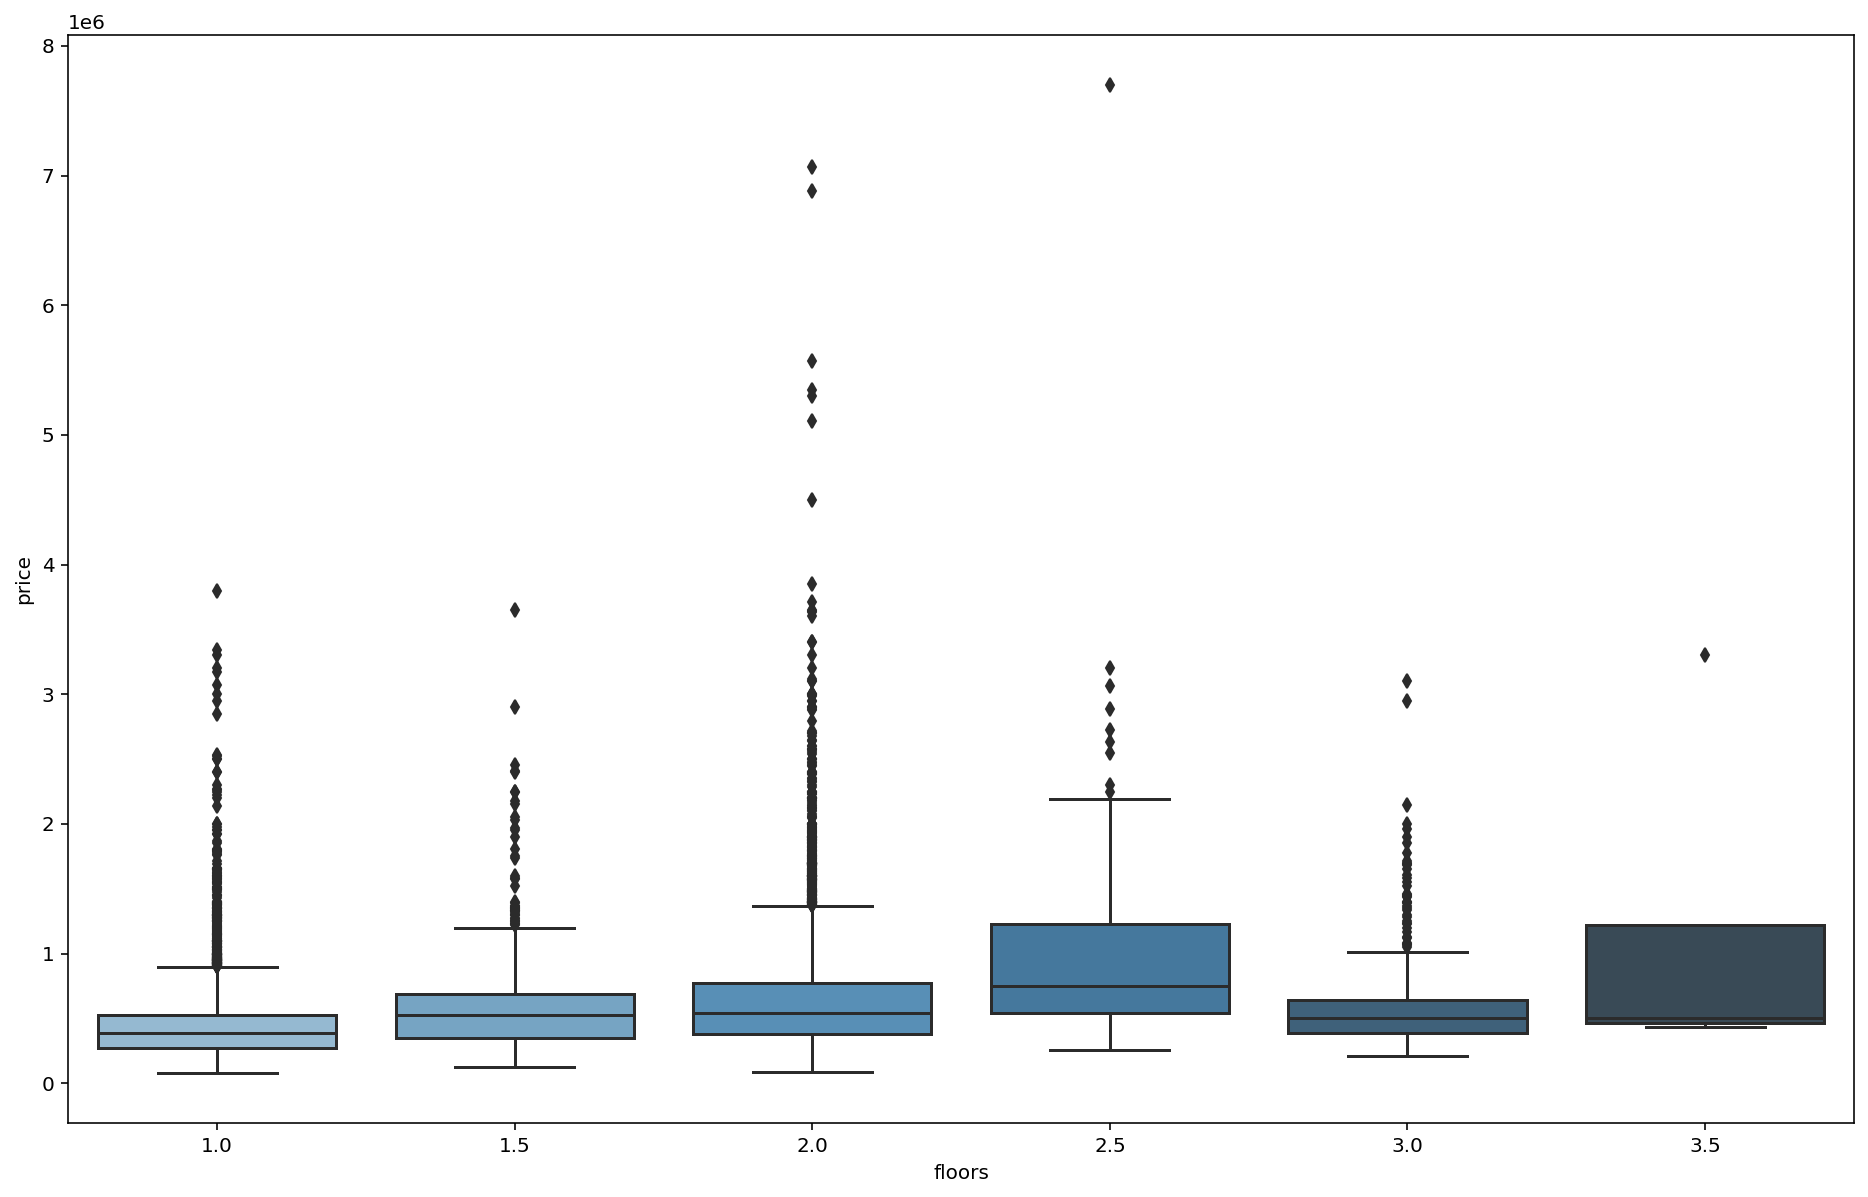

In [39]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.boxplot(x = df_train["floors"], y = df_train["price"], data = df_train, ax = ax, palette = "Blues_d")

In [40]:
df_train.loc[(df_train.floors==2.5) & (df_train.price > 6*10**6)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
5108,201410,7700000.0,6,8.0,12050,27600,2.5,0,3,4,...,3480,1910,1987,98102,47.6298,-122.323,3940,8800,10,14


sqft_living이 매우 큰 것으로 보아 이상치 X

In [41]:
print(df_train[df_train['floors']==2.5].sqft_living.mean())

3075.7699115044247


#### waterfront - price

리버뷰면 가격 높음.

In [42]:
df_train[["waterfront", "price"]].groupby(["waterfront"], as_index = True).describe()

price                                                  \
              count          mean           std       min       25%   
waterfront                                                            
0           14925.0  5.322423e+05  3.449987e+05   78000.0  320000.0   
1             107.0  1.706784e+06  1.186021e+06  285000.0  780000.0   

                                             
                  50%        75%        max  
waterfront                                   
0            450000.0   640000.0  7700000.0  
1           1517000.0  2215000.0  7062500.0

<AxesSubplot:xlabel='waterfront', ylabel='price'>

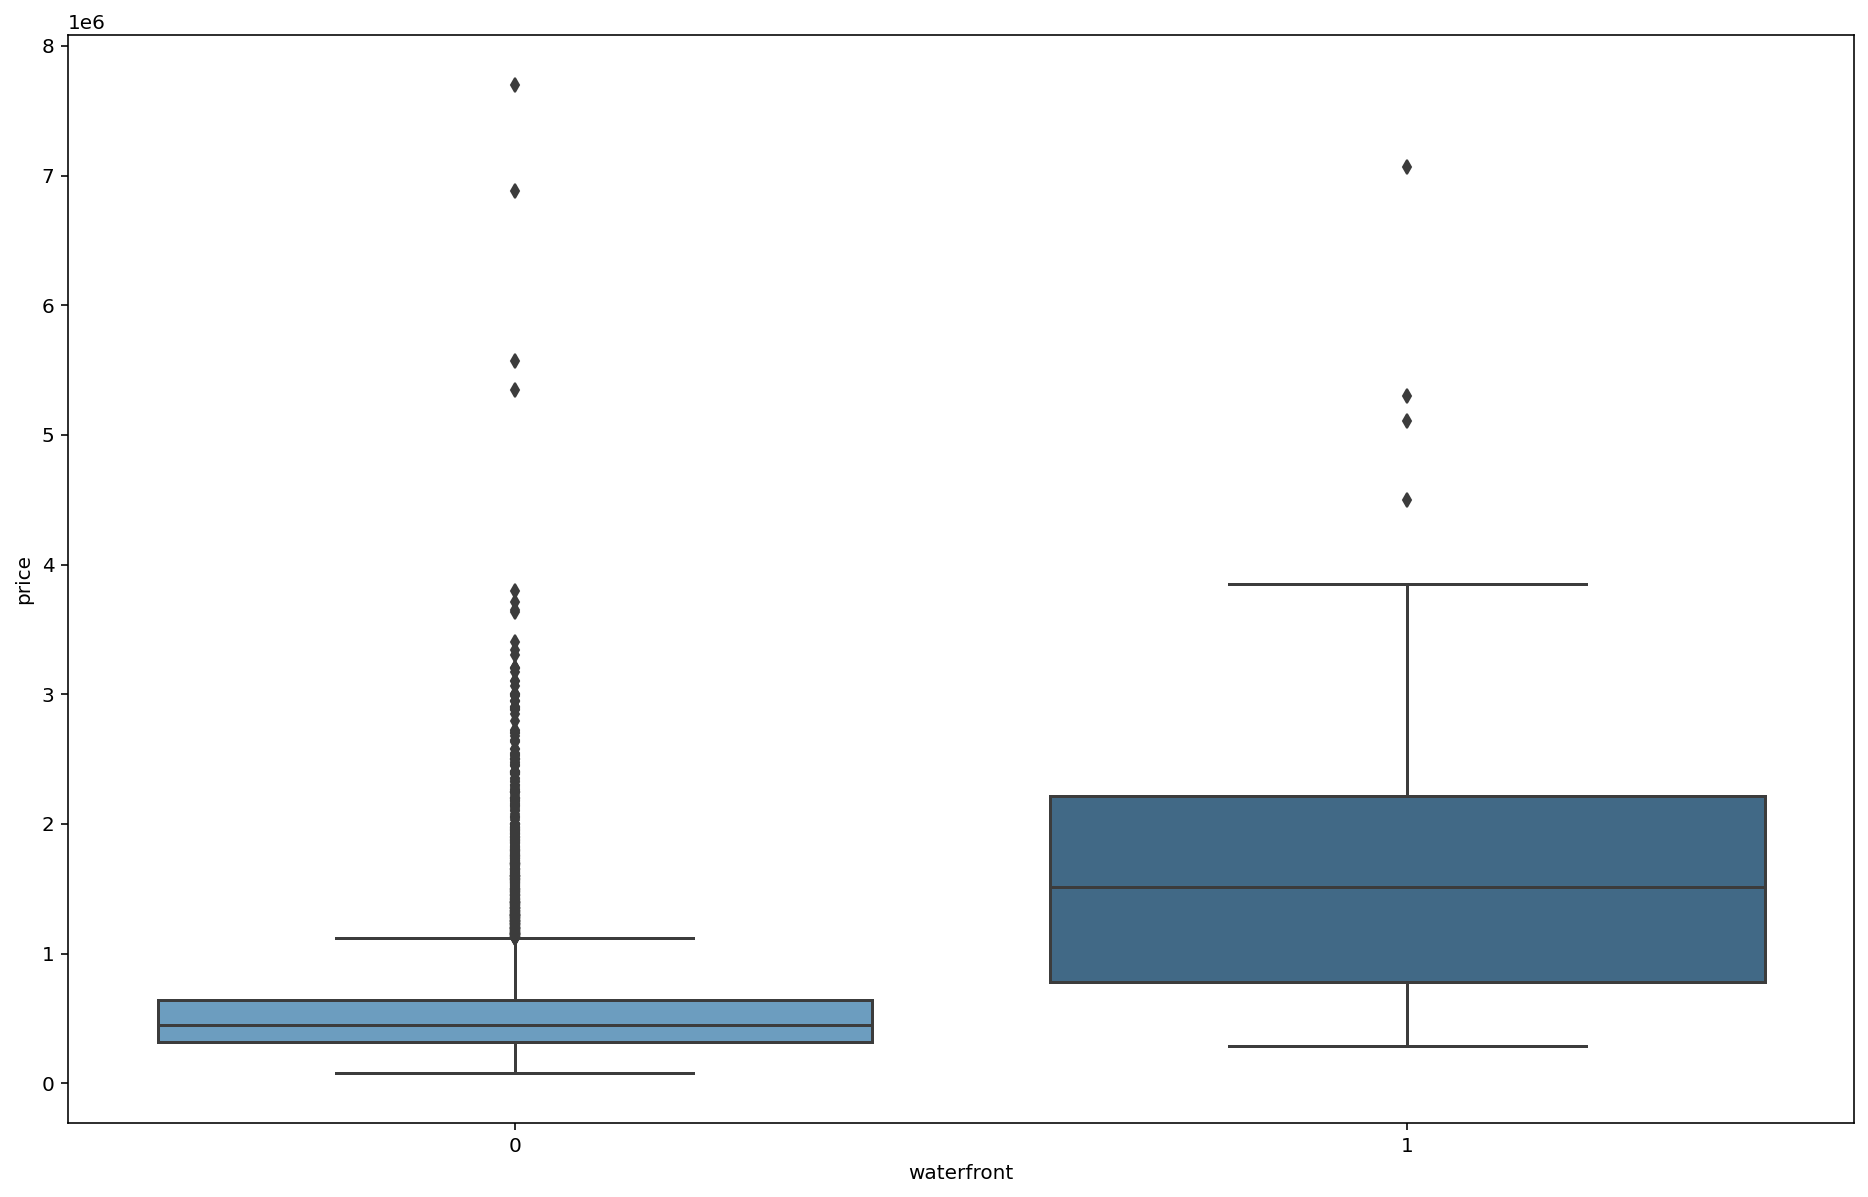

In [43]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.boxplot(x = df_train["waterfront"], y = df_train["price"], data = df_train, ax = ax, palette = "Blues_d")

In [44]:
df_train.loc[(df_train.waterfront==0) & (df_train.price > 5*10**6)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
1045,201504,5350000.0,5,5.00,8000,23985,2.0,0,4,3,...,1280,2009,0,98004,47.6232,-122.220,4600,21750,4,15
3134,201408,5570000.0,5,5.75,9200,35069,2.0,0,0,3,...,3000,2001,0,98039,47.6289,-122.233,3560,24345,8,14
5108,201410,7700000.0,6,8.00,12050,27600,2.5,0,3,4,...,3480,1910,1987,98102,47.6298,-122.323,3940,8800,10,14
6469,201409,6885000.0,6,7.75,9890,31374,2.0,0,4,3,...,1030,2001,0,98039,47.6305,-122.240,4540,42730,9,14


sqft_living이 매우 큰 것응로 보아 이상치 X

#### view - price

선형 관계. 

In [45]:
df_train[["view", "price"]].groupby(["view"], as_index = True).describe()

price                                                             \
        count          mean           std       min       25%        50%   
view                                                                       
0     13546.0  4.963190e+05  2.844084e+05   78000.0  311000.0   433000.0   
1       241.0  7.872060e+05  5.083995e+05  217000.0  480000.0   670000.0   
2       665.0  8.056546e+05  5.437523e+05  169317.0  485000.0   680000.0   
3       373.0  9.866276e+05  6.457858e+05  154000.0  560000.0   800000.0   
4       207.0  1.496211e+06  1.013704e+06  252000.0  815000.0  1185000.0   

                            
            75%        max  
view                        
0      600000.0  5570000.0  
1      875000.0  3650000.0  
2      950000.0  7062500.0  
3     1298000.0  7700000.0  
4     1898500.0  6885000.0

<AxesSubplot:xlabel='view', ylabel='price'>

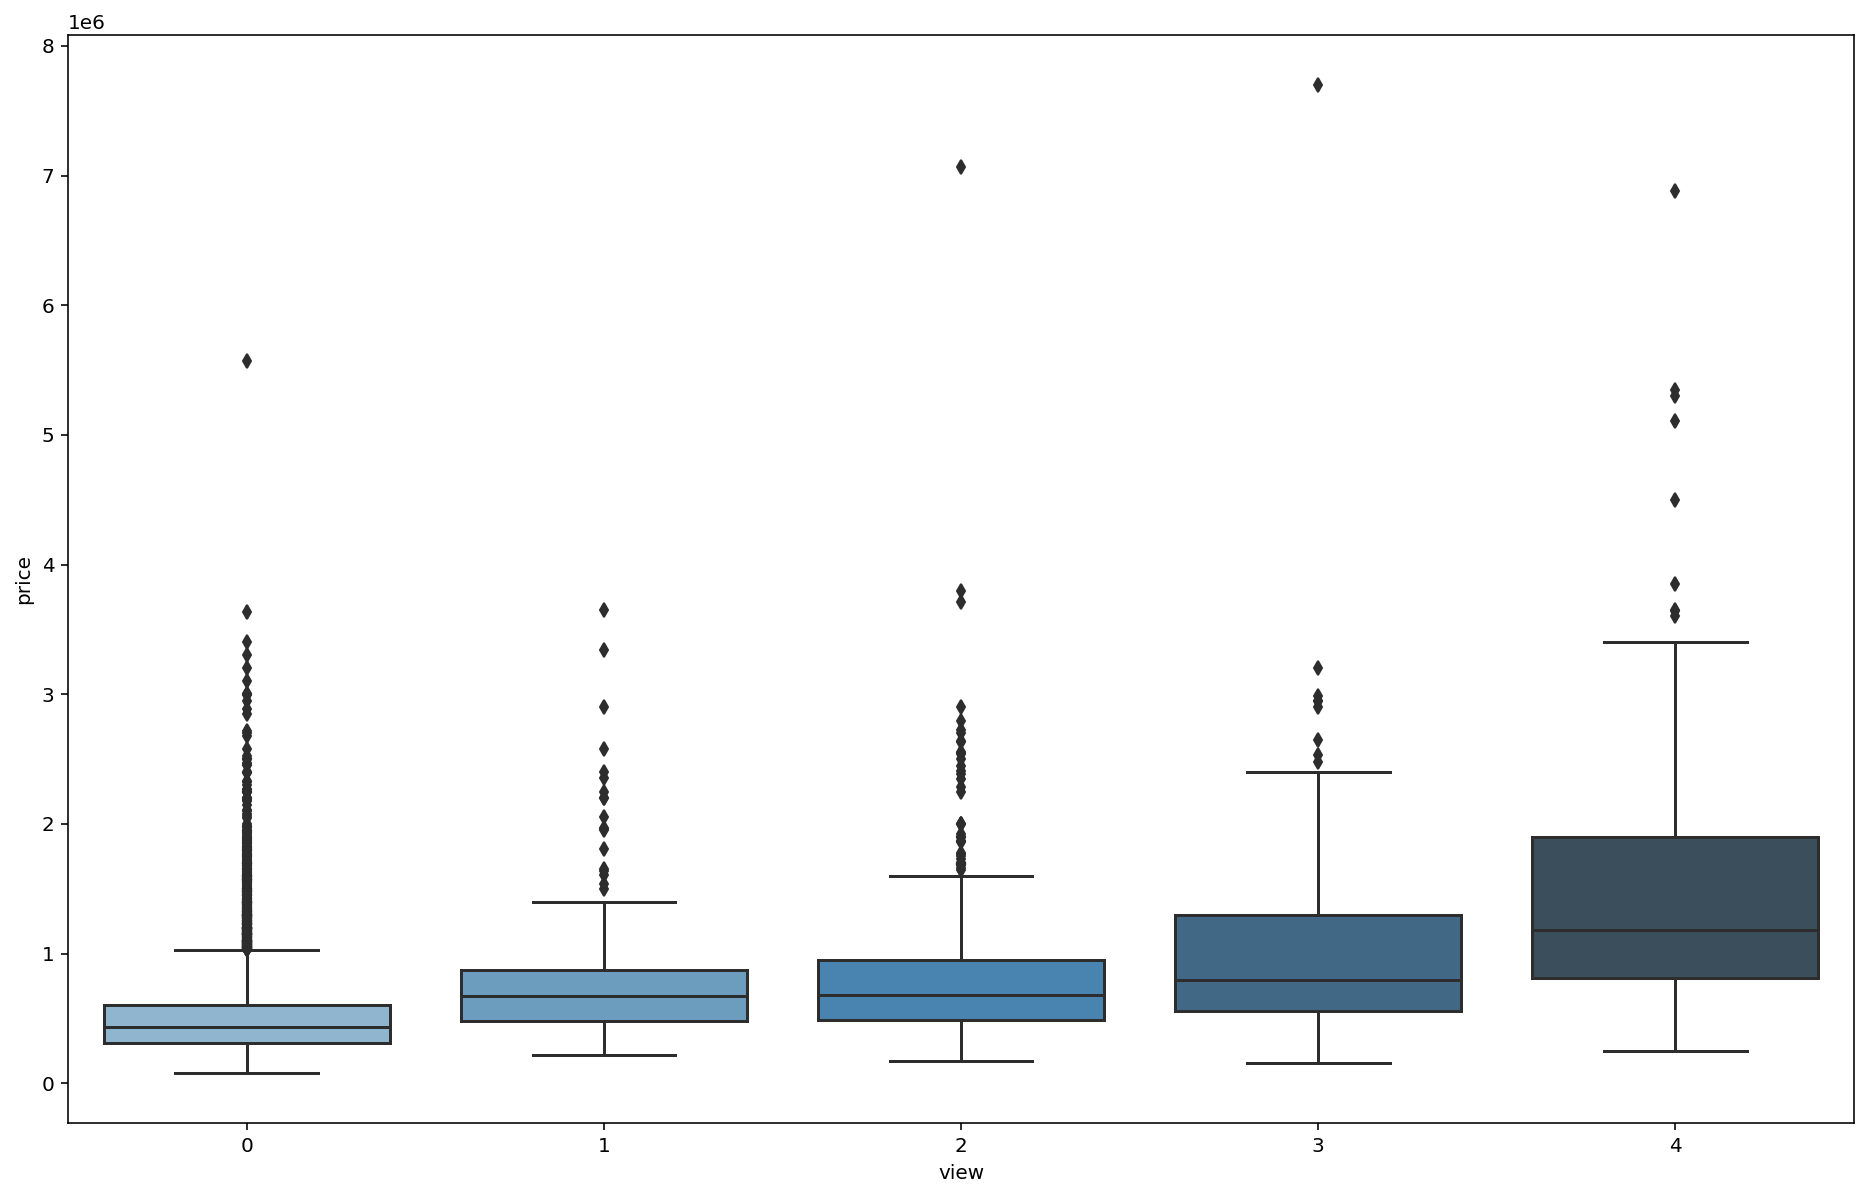

In [46]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.boxplot(x = df_train["view"], y = df_train["price"], data = df_train, ax = ax, palette = "Blues_d")

sqft_living이 매우 큰것으로 보아 이상치 X

In [47]:
df_train.loc[(df_train.view==0) & (df_train.price > 5*10**6)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
3134,201408,5570000.0,5,5.75,9200,35069,2.0,0,0,3,...,3000,2001,0,98039,47.6289,-122.233,3560,24345,8,14


#### condition - price

condition 3~4 사이에 이상치 ?? 

In [48]:
df_train[["condition", "price"]].groupby(["condition"], as_index = True).describe()

price                                                              \
            count           mean            std       min       25%       50%   
condition                                                                       
1            21.0  276592.857143  171129.508184   78000.0  130000.0  252000.0   
2           109.0  325643.889908  273682.635929   80000.0  188000.0  279000.0   
3          9792.0  540884.940768  364975.978426   83000.0  329945.5  450000.0   
4          3956.0  526107.457533  371959.694139   89000.0  305000.0  445000.0   
5          1154.0  613008.331023  414920.035939  110000.0  350000.0  525000.0   

                                
                75%        max  
condition                       
1          380000.0   658000.0  
2          396400.0  2555000.0  
3          640000.0  7062500.0  
4          635000.0  7700000.0  
5          725000.0  3650000.0

<AxesSubplot:xlabel='condition', ylabel='price'>

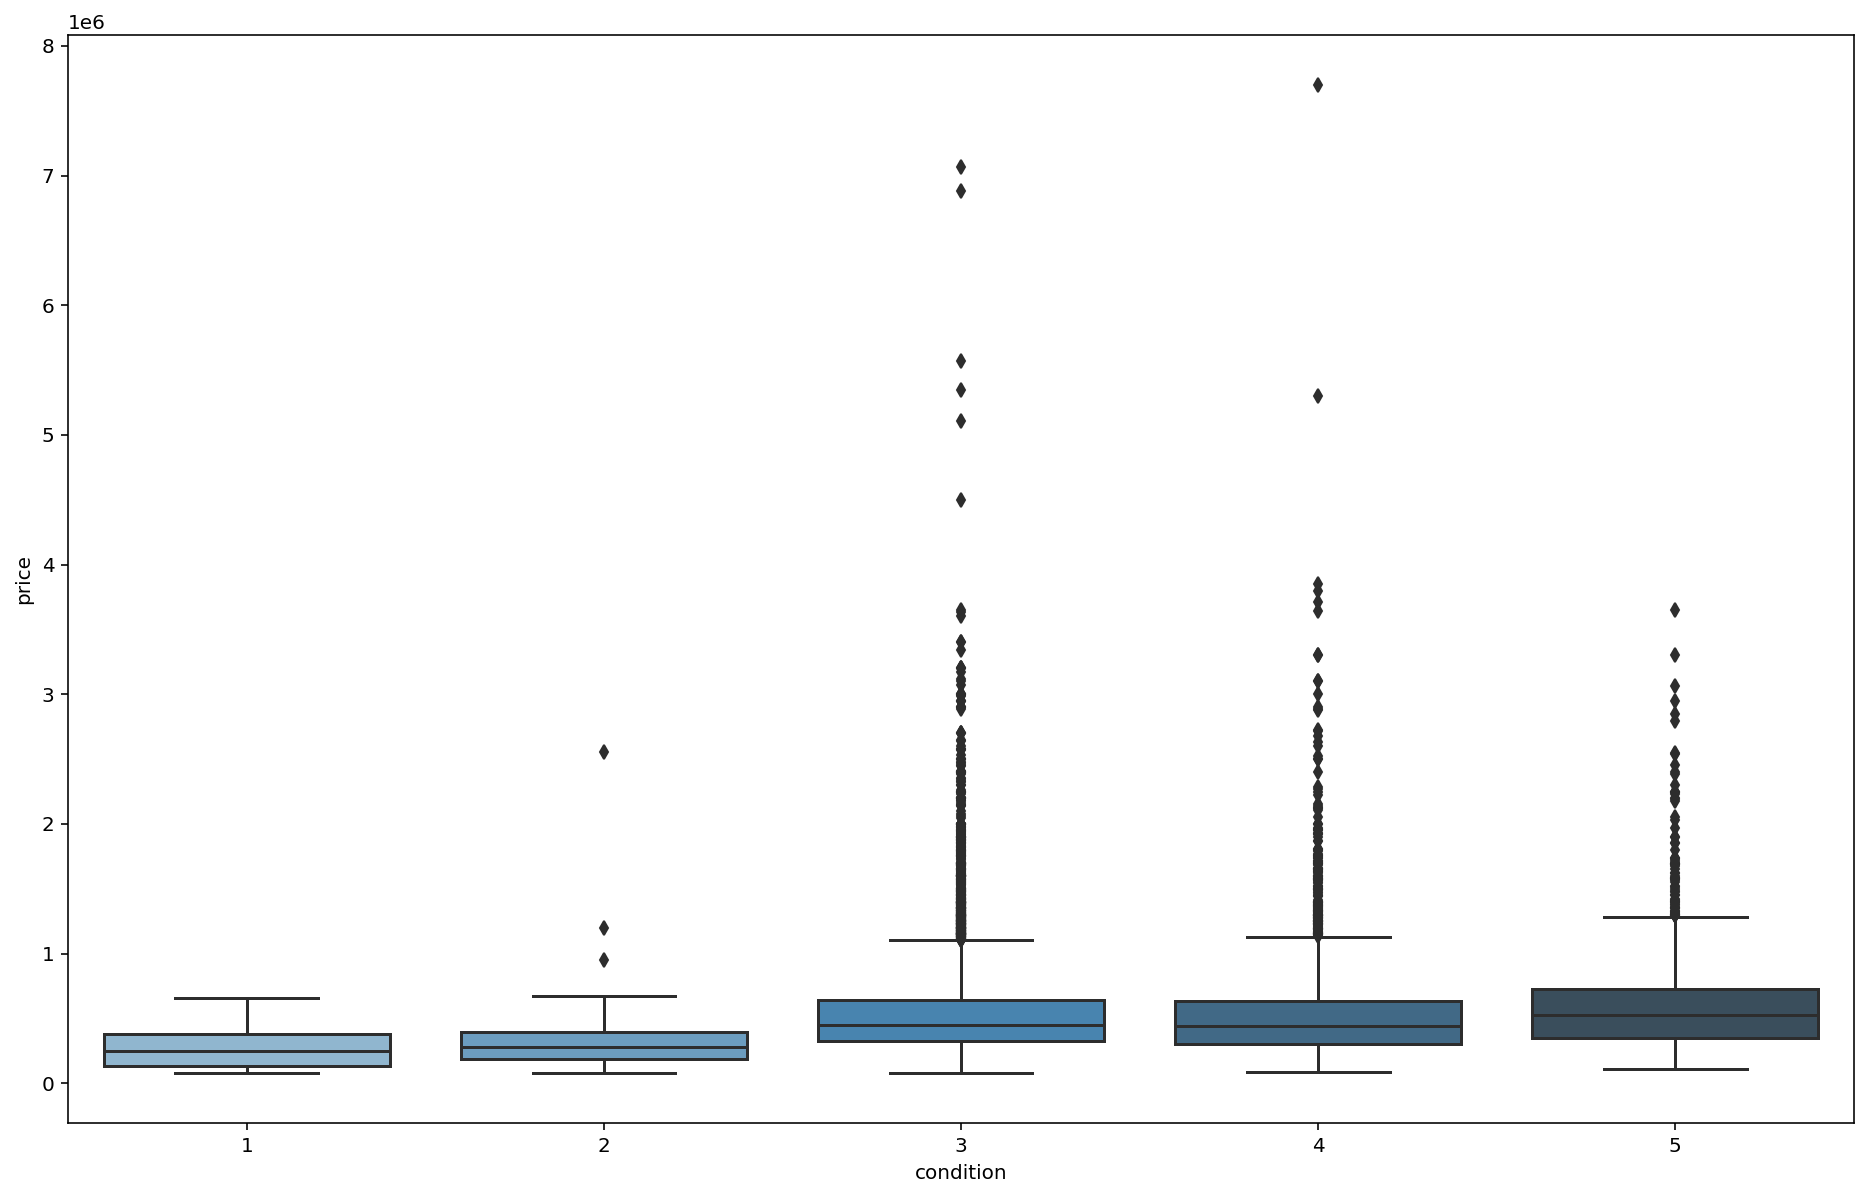

In [49]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.boxplot(x = df_train["condition"], y = df_train["price"], data = df_train, ax = ax, palette = "Blues_d")

In [50]:
df_train.loc[(df_train.condition==3) & (df_train.price > 4*10**6)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
842,201410,5110800.0,5,5.25,8010,45517,2.0,1,4,3,...,2020,1999,0,98033,47.6767,-122.211,3430,26788,10,14
1045,201504,5350000.0,5,5.00,8000,23985,2.0,0,4,3,...,1280,2009,0,98004,47.6232,-122.220,4600,21750,4,15
1882,201408,4500000.0,5,5.50,6640,40014,2.0,1,4,3,...,290,2004,0,98155,47.7493,-122.280,3030,23408,8,14
2775,201406,7062500.0,5,4.50,10040,37325,2.0,1,2,3,...,2360,1940,2001,98004,47.6500,-122.214,3930,25449,6,14
3134,201408,5570000.0,5,5.75,9200,35069,2.0,0,0,3,...,3000,2001,0,98039,47.6289,-122.233,3560,24345,8,14
6469,201409,6885000.0,6,7.75,9890,31374,2.0,0,4,3,...,1030,2001,0,98039,47.6305,-122.240,4540,42730,9,14


sqft_living은 작지만 나머지 특성들은 일반적인 값을 가지고 있어 이상치 X로 생각.

### 분포 확인

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

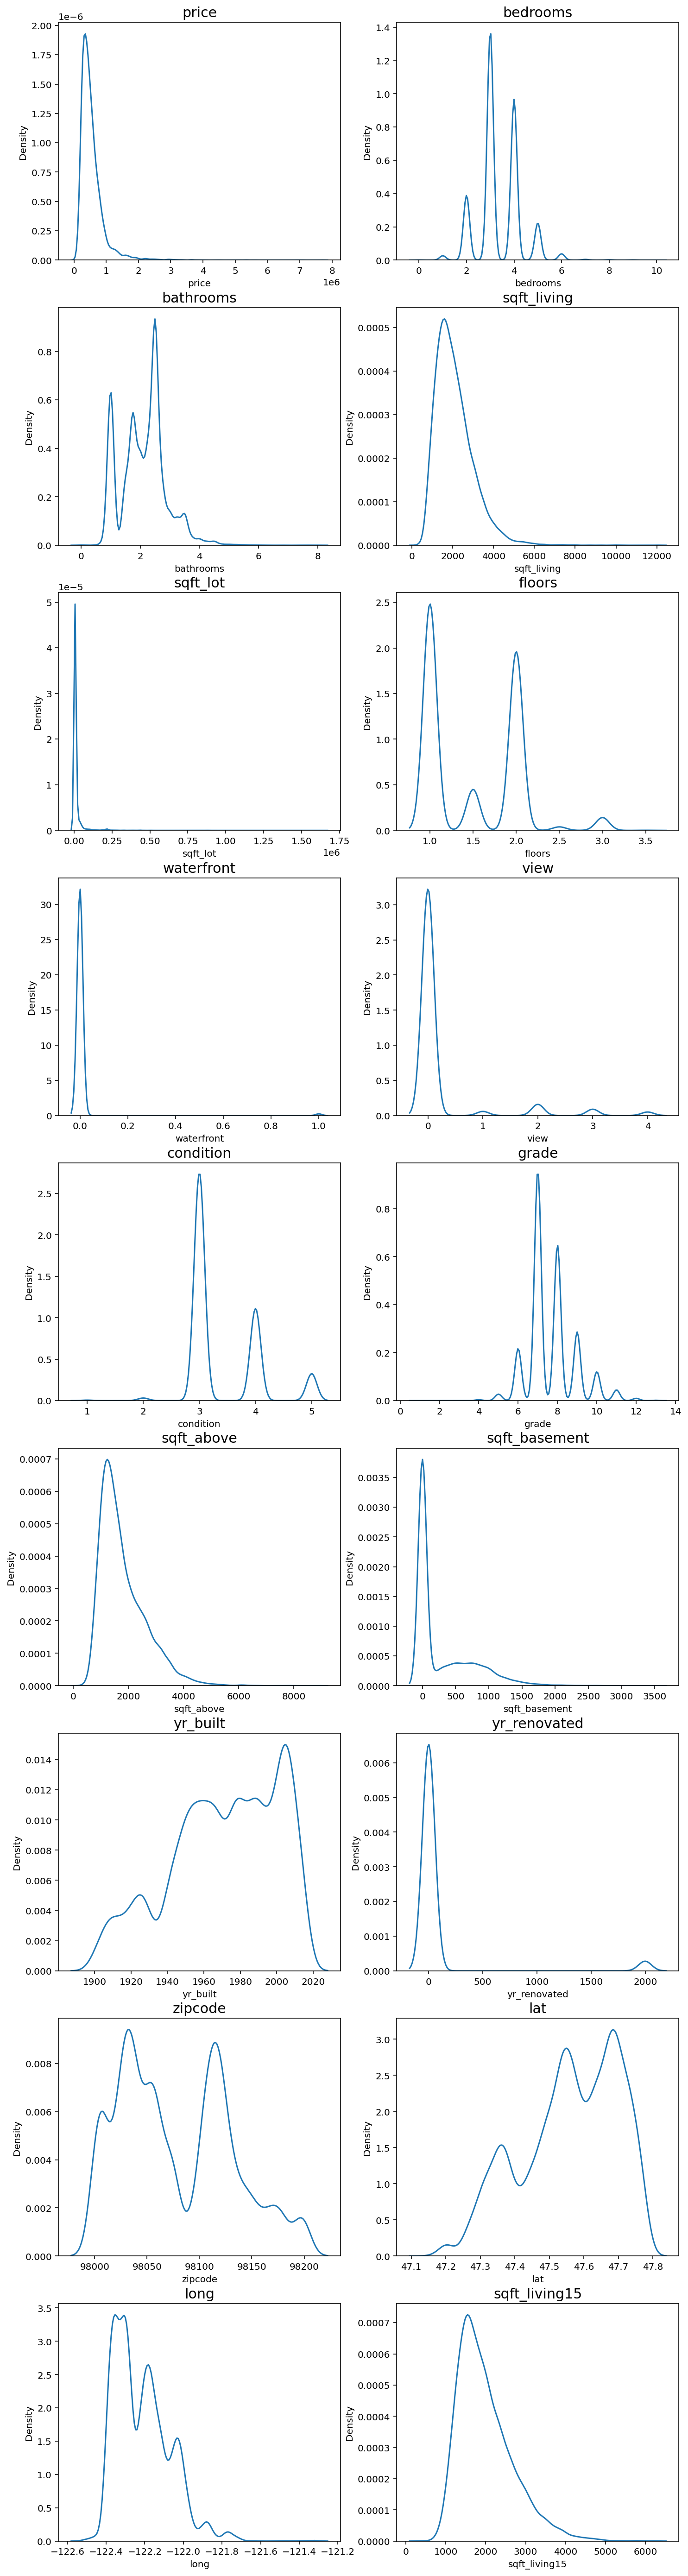

In [51]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# id 변수는 제외하고 분포를 확인합니다.
count = 1
columns = df_train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(df_train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

In [52]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

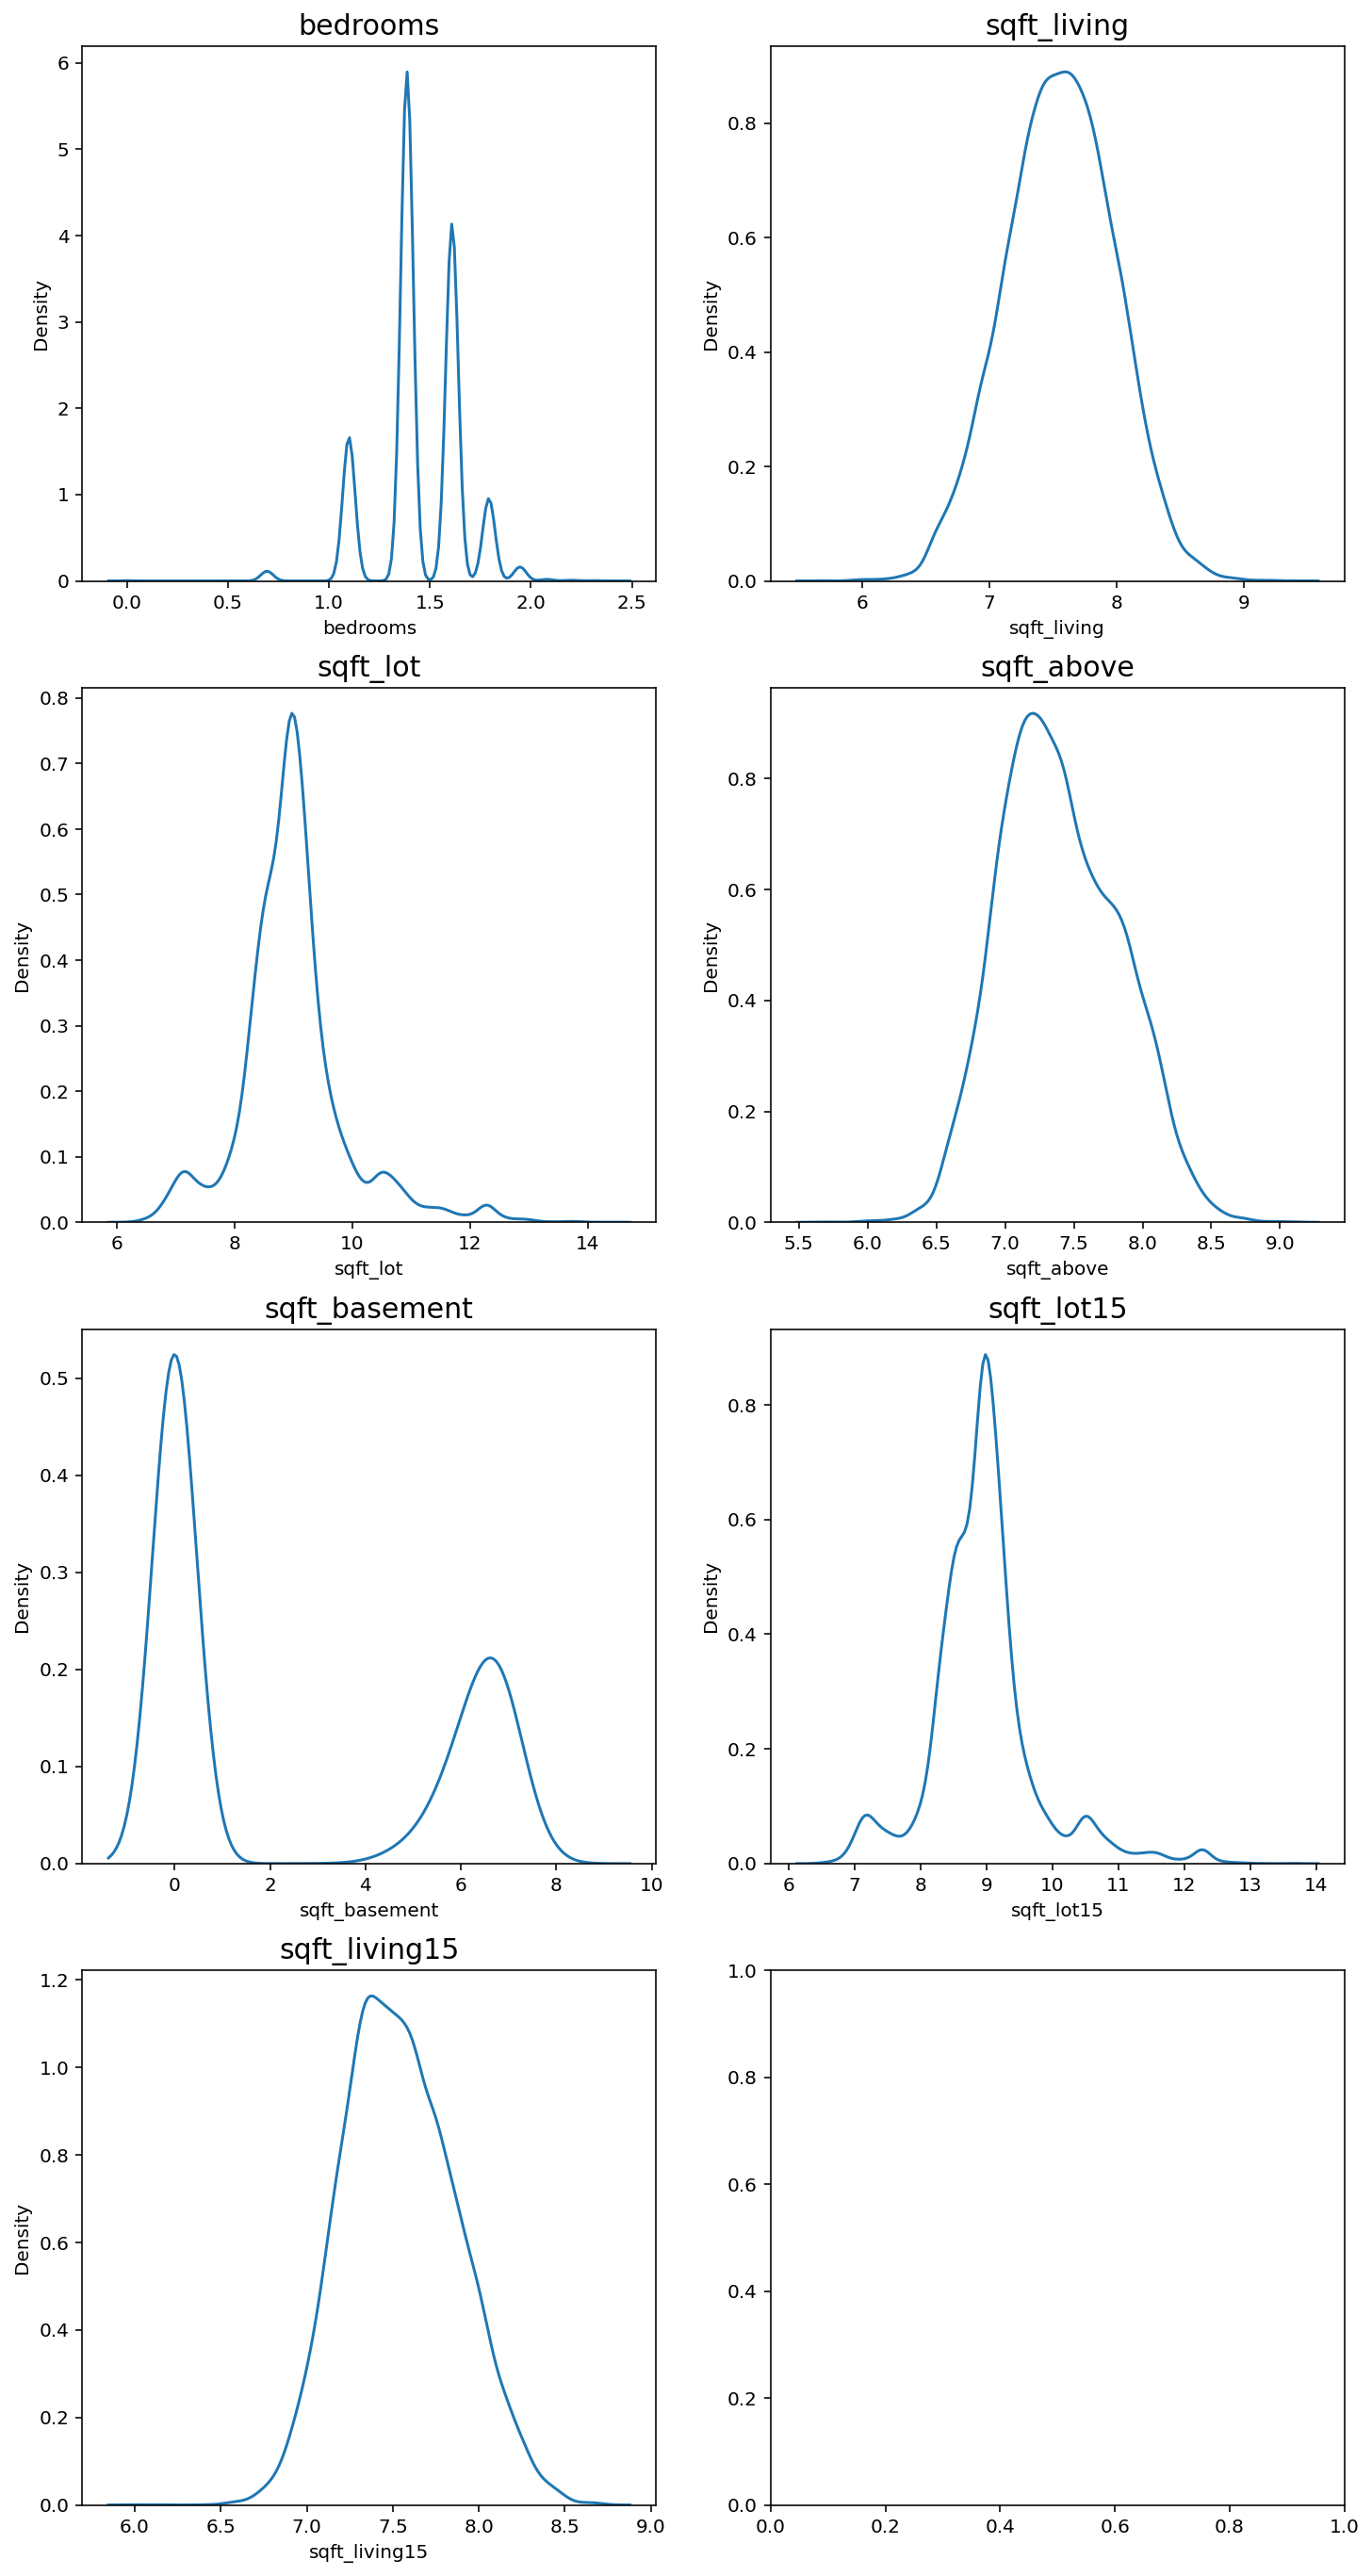

In [53]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(df_train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



<AxesSubplot:xlabel='price', ylabel='Density'>

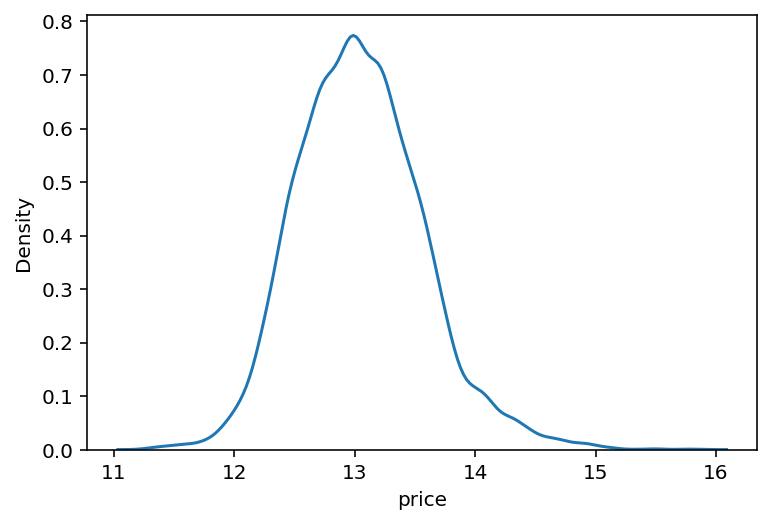

In [54]:
df_train['price'] = np.log1p(df_train['price'])

sns.kdeplot(df_train['price'])

### 특성 추가

용적율 , 재건축 여부 

In [55]:
df_train["Vol_ratio"] = (df_train["sqft_living"] / df_train["sqft_lot"]) * 100
df_test["Vol_ratio"] = (df_test["sqft_living"] / df_test["sqft_lot"]) * 100

# 용적률 = 건물연면적 / 토지면적 * 100

df_train['is_renovated'] = df_train['yr_renovated'] - df_train['yr_built']
df_train['is_renovated'] = df_train['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
df_test['is_renovated'] = df_test['yr_renovated'] - df_test['yr_built']
df_test['is_renovated'] = df_test['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

In [56]:
del df_train["date"]
del df_test['date']

df_label = df_train['price']
del df_train['price']

In [57]:
df_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year,Vol_ratio,is_renovated
0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,...,0,98178,47.5112,-122.257,7.201171,8.639588,10,14,81.880258,1
1,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,...,0,98028,47.7379,-122.233,7.908755,8.995041,2,15,72.175576,1
2,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,...,0,98074,47.6168,-122.045,7.496097,8.923191,2,15,82.548855,1
3,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,...,0,98003,47.3097,-122.327,7.713785,8.827615,6,14,84.368785,1
4,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,...,0,98198,47.4095,-122.315,7.409136,9.181118,1,15,75.883651,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,1.609438,2.50,7.832411,8.703507,2.0,0,0,3,9,7.832411,...,0,98056,47.5137,-122.167,7.832411,8.703507,10,14,89.991438,1
15031,1.609438,3.50,8.163656,8.881975,2.0,0,0,3,9,7.863651,...,0,98136,47.5537,-122.398,7.626083,8.732466,3,15,91.912621,1
15032,1.386294,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,...,0,98103,47.6993,-122.346,7.333676,7.319865,5,14,104.293889,1
15033,1.609438,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,...,0,98146,47.5107,-122.362,7.512618,8.881975,2,15,89.356415,1


In [58]:
df_test

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year,Vol_ratio,is_renovated
0,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,...,1991,98125,47.7210,-122.319,7.433075,8.941153,12,14,88.346479,1
1,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,...,0,98136,47.5208,-122.393,7.215975,8.517393,12,14,89.008570,1
2,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,...,0,98053,47.6561,-122.005,8.468213,11.532051,5,14,74.557729,1
3,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,...,0,98146,47.5123,-122.337,7.484930,9.001346,4,15,83.923214,1
4,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,...,0,98038,47.3684,-122.031,7.779467,8.932080,3,15,85.845356,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,1.386294,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,...,0,98010,47.3095,-122.002,7.186144,9.332912,6,14,77.889544,1
6464,1.386294,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,...,0,98144,47.5699,-122.288,7.244942,7.115582,1,15,103.982856,1
6465,1.386294,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,...,0,98116,47.5773,-122.409,7.193686,7.143618,2,15,100.171352,1
6466,1.098612,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,...,0,98144,47.5944,-122.299,6.928538,7.604894,6,14,96.114884,1


In [59]:
df_label

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15032, dtype: float64

## 4. 모델링


## LGBM

In [61]:
train_columns = df_train.columns
df_label = np.expm1(df_label)

In [67]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

folds = KFold(n_splits=5, shuffle=True, random_state=1)
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx], label=df_label.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx], label=df_label.iloc[val_idx])
    
    num_round = 10000
    lgb1 = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = lgb1.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += lgb1.predict(df_test, num_iteration=lgb1.best_iteration) / folds.n_splits

Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 104143	valid_1's rmse: 114053
Early stopping, best iteration is:
[858]	training's rmse: 91304.5	valid_1's rmse: 113007
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 102568	valid_1's rmse: 127180
Early stopping, best iteration is:
[441]	training's rmse: 105692	valid_1's rmse: 126949
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 100471	valid_1's rmse: 139234
[1000]	training's rmse: 85438.1	valid_1's rmse: 134681
[1500]	training's rmse: 75561.7	valid_1's rmse: 132978
Early stopping, best iteration is:
[1646]	training's rmse: 73312.7	valid_1's rmse: 132621
[LightGBM] [Warning] min_data_in_l

In [72]:
lgb1_sub = pd.DataFrame()
lgb1_sub['id'] = test_id
lgb1_sub['price'] = predictions

#### 위치 정보와 면적과 관련된 부분이 집값 측정에 큰 비중을 차지 함을 확인할 수 있었다.

is_renovated의 경우 매우 적은 영향을 주어 특성을 제거하는 것이 나을 거 같다.

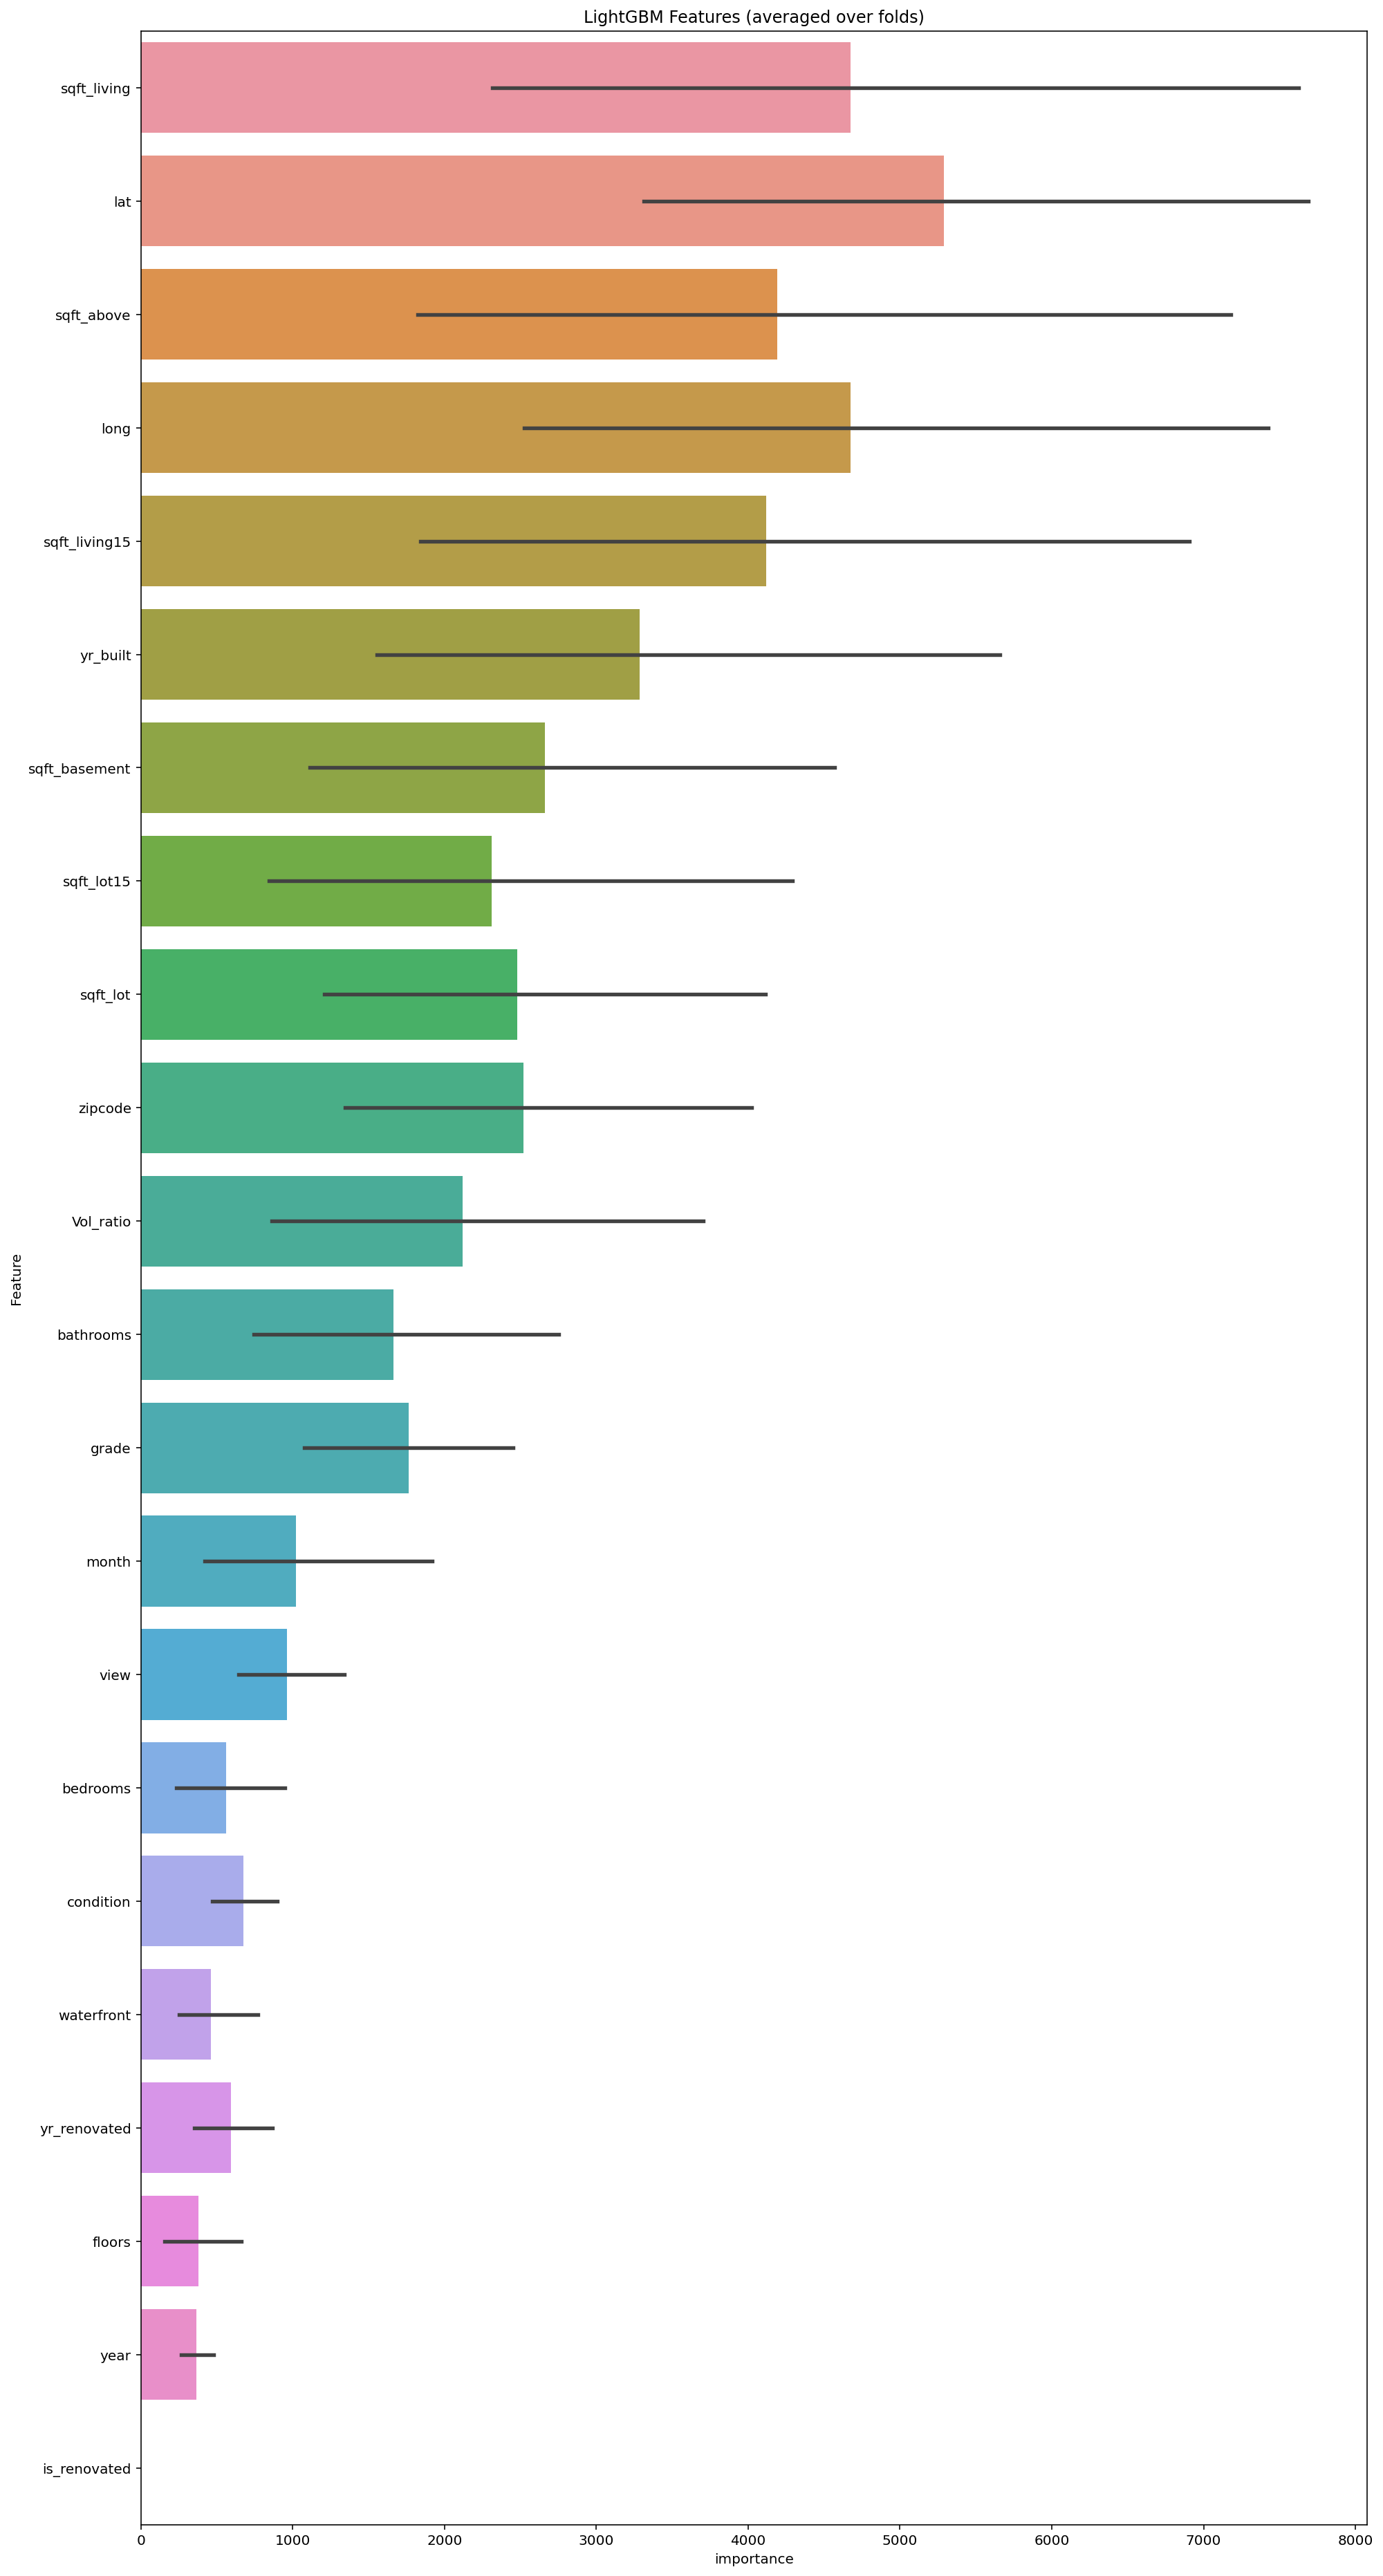

In [68]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

### XGB

In [73]:
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(df_train, df_label)
dtest = xgb.DMatrix(df_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=50, verbose_eval=500, show_stdv=False)

rounds=len(cv_output)

xgb1 = xgb.train(xgb_params, dtrain, num_boost_round=rounds)
preds = xgb1.predict(dtest)

xgb1_sub = pd.DataFrame()
xgb1_sub['id'] = test_id
xgb1_sub['price'] = preds

[13:10:05] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:05] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:10:05] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:05] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:10:05] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squar

### RF

In [84]:
forest_regr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=22, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

rf = forest_regr.fit(df_train, df_label)
predictions = rf.predict(df_test)

rf_sub = pd.DataFrame()
rf_sub['id'] = test_id
rf_sub['price'] = predictions

### GB

In [80]:
gdb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

gdb.fit(df_train, df_label)
predictions = gdb.predict(df_test)

gdb_sub = pd.DataFrame()
gdb_sub['id'] = test_id
gdb_sub['price'] = predictions

### ENSEMBEL

In [95]:
xgb_train_pred = xgb1.predict(dtrain)
lgb_train_pred = lgb1.predict(df_train)
gdb_train_pred = gdb.predict(df_train)
rf_train_pred = rf.predict(df_train)
mse = {}

ii = np.arange(0, 0.1, 0.01)

for i, ii in enumerate(ii):
    submse={}
    train_pred = 0.5*xgb_train_pred + (0.4-ii)*lgb_train_pred + 0.1*gdb_train_pred + ii*rf_train_pred
    mse[i] = np.sqrt(mean_squared_error(df_label, train_pred))  
train_min = min(mse.values())

for i in range(10):
    if mse[i] == train_min:
        print(i)

9


### 최종 모델 : XGB 0.5 + LGBM 0.32  + GDB 0.1 + RF 0.08

In [96]:
my_submission_path = join(data_dir, 'submission_ensemble.csv')

ensemble_sub = pd.DataFrame()

ensemble_sub['id'] = test_id
ensemble_sub['price'] = xgb1_sub['price']*0.5 + lgb1_sub['price']*0.32 + gdb_sub['price']*0.1 + rf_sub['price']*0.08
ensemble_sub.to_csv(my_submission_path, index=False)

![image](https://user-images.githubusercontent.com/86637320/128886260-355304f2-7243-4ecb-ad0c-3e658c70c564.png)

## 정리

- 이 노트북은 submission_ensemble(1)에 진행된 과정을 복원한 것이다.

- 캐글 해커톤 전에 캐글에 대해서 경험하기 위해서 진행했던 데이터 분석 과제이다.

생각보다 socre가 좀처럼 떨어지지 않아서 대회가 끝나고 많은 시간이 지나서야 제출할 수 있었다.   

부족했던 부분들은 캐글 해커톤 이후에 채워나갔다. 특성 별 이상치를 찾아 제거하였고 도움이 될 법한 특성들을 새로 추가하기도 했다. (용적율, 재건축 여부) 

점수를 더 낮추고자 여러 모델들을 모아 ensemble 기법을 사용했고 결국 원하는 score를 얻을 수 있었다. 

모델 최적의 hyper-parameter를 찾기 위해서 grid-search를 진행했었지만 결과 값이 잘 나오지 않아서 일반적으로 사용되는 값을 그냥 사용했다. 이 부분은 나중에 개선해야 할 것이다.

**Feature Engineering** 때 보다도 **ensemble** 기법을 활용하면서 score가 많이 개선됐다. 

시각화 방법이나 모델링 방법의 경우 아래 커널을 참조했다.

[house-price-prediction-eda-updated-2019-03-12](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)   
[boaz-mini-project](https://www.kaggle.com/kongnyooong/boaz-mini-project)